
===== Starting TF-IDF Analysis (References Excluded, Table A2) =====
Found 26 PDF files to process for TF-IDF.
--- Processing How can urban blue-green space be planned for climate adaption in high-latitude cities? A seasonal perspective.pdf ---
--- Processing Hyperlocal mapping of urban air temperature using remote sensing and crowdsourced weather data.pdf ---
--- Processing Terrain-sensitive carbon management for SDG11- A spatial-explicit assessment of mountainous cities under climate and urbanization pressures.pdf ---
--- Processing Urban Form Compaction and Energy Use Intensity in New Social Housing Neighborhoods in the UAE.pdf ---
--- Processing Greening metropolitan growth  integrating nature recreation  compactness and spaciousness in regional development planning.pdf ---
--- Processing Spatiotemporal Heterogeneity and Socioeconomic Drivers of Landscape Patterns in High-Density Communities of Wuhan.pdf ---
--- Processing Evaluation of urban land-use structures with a view to sus

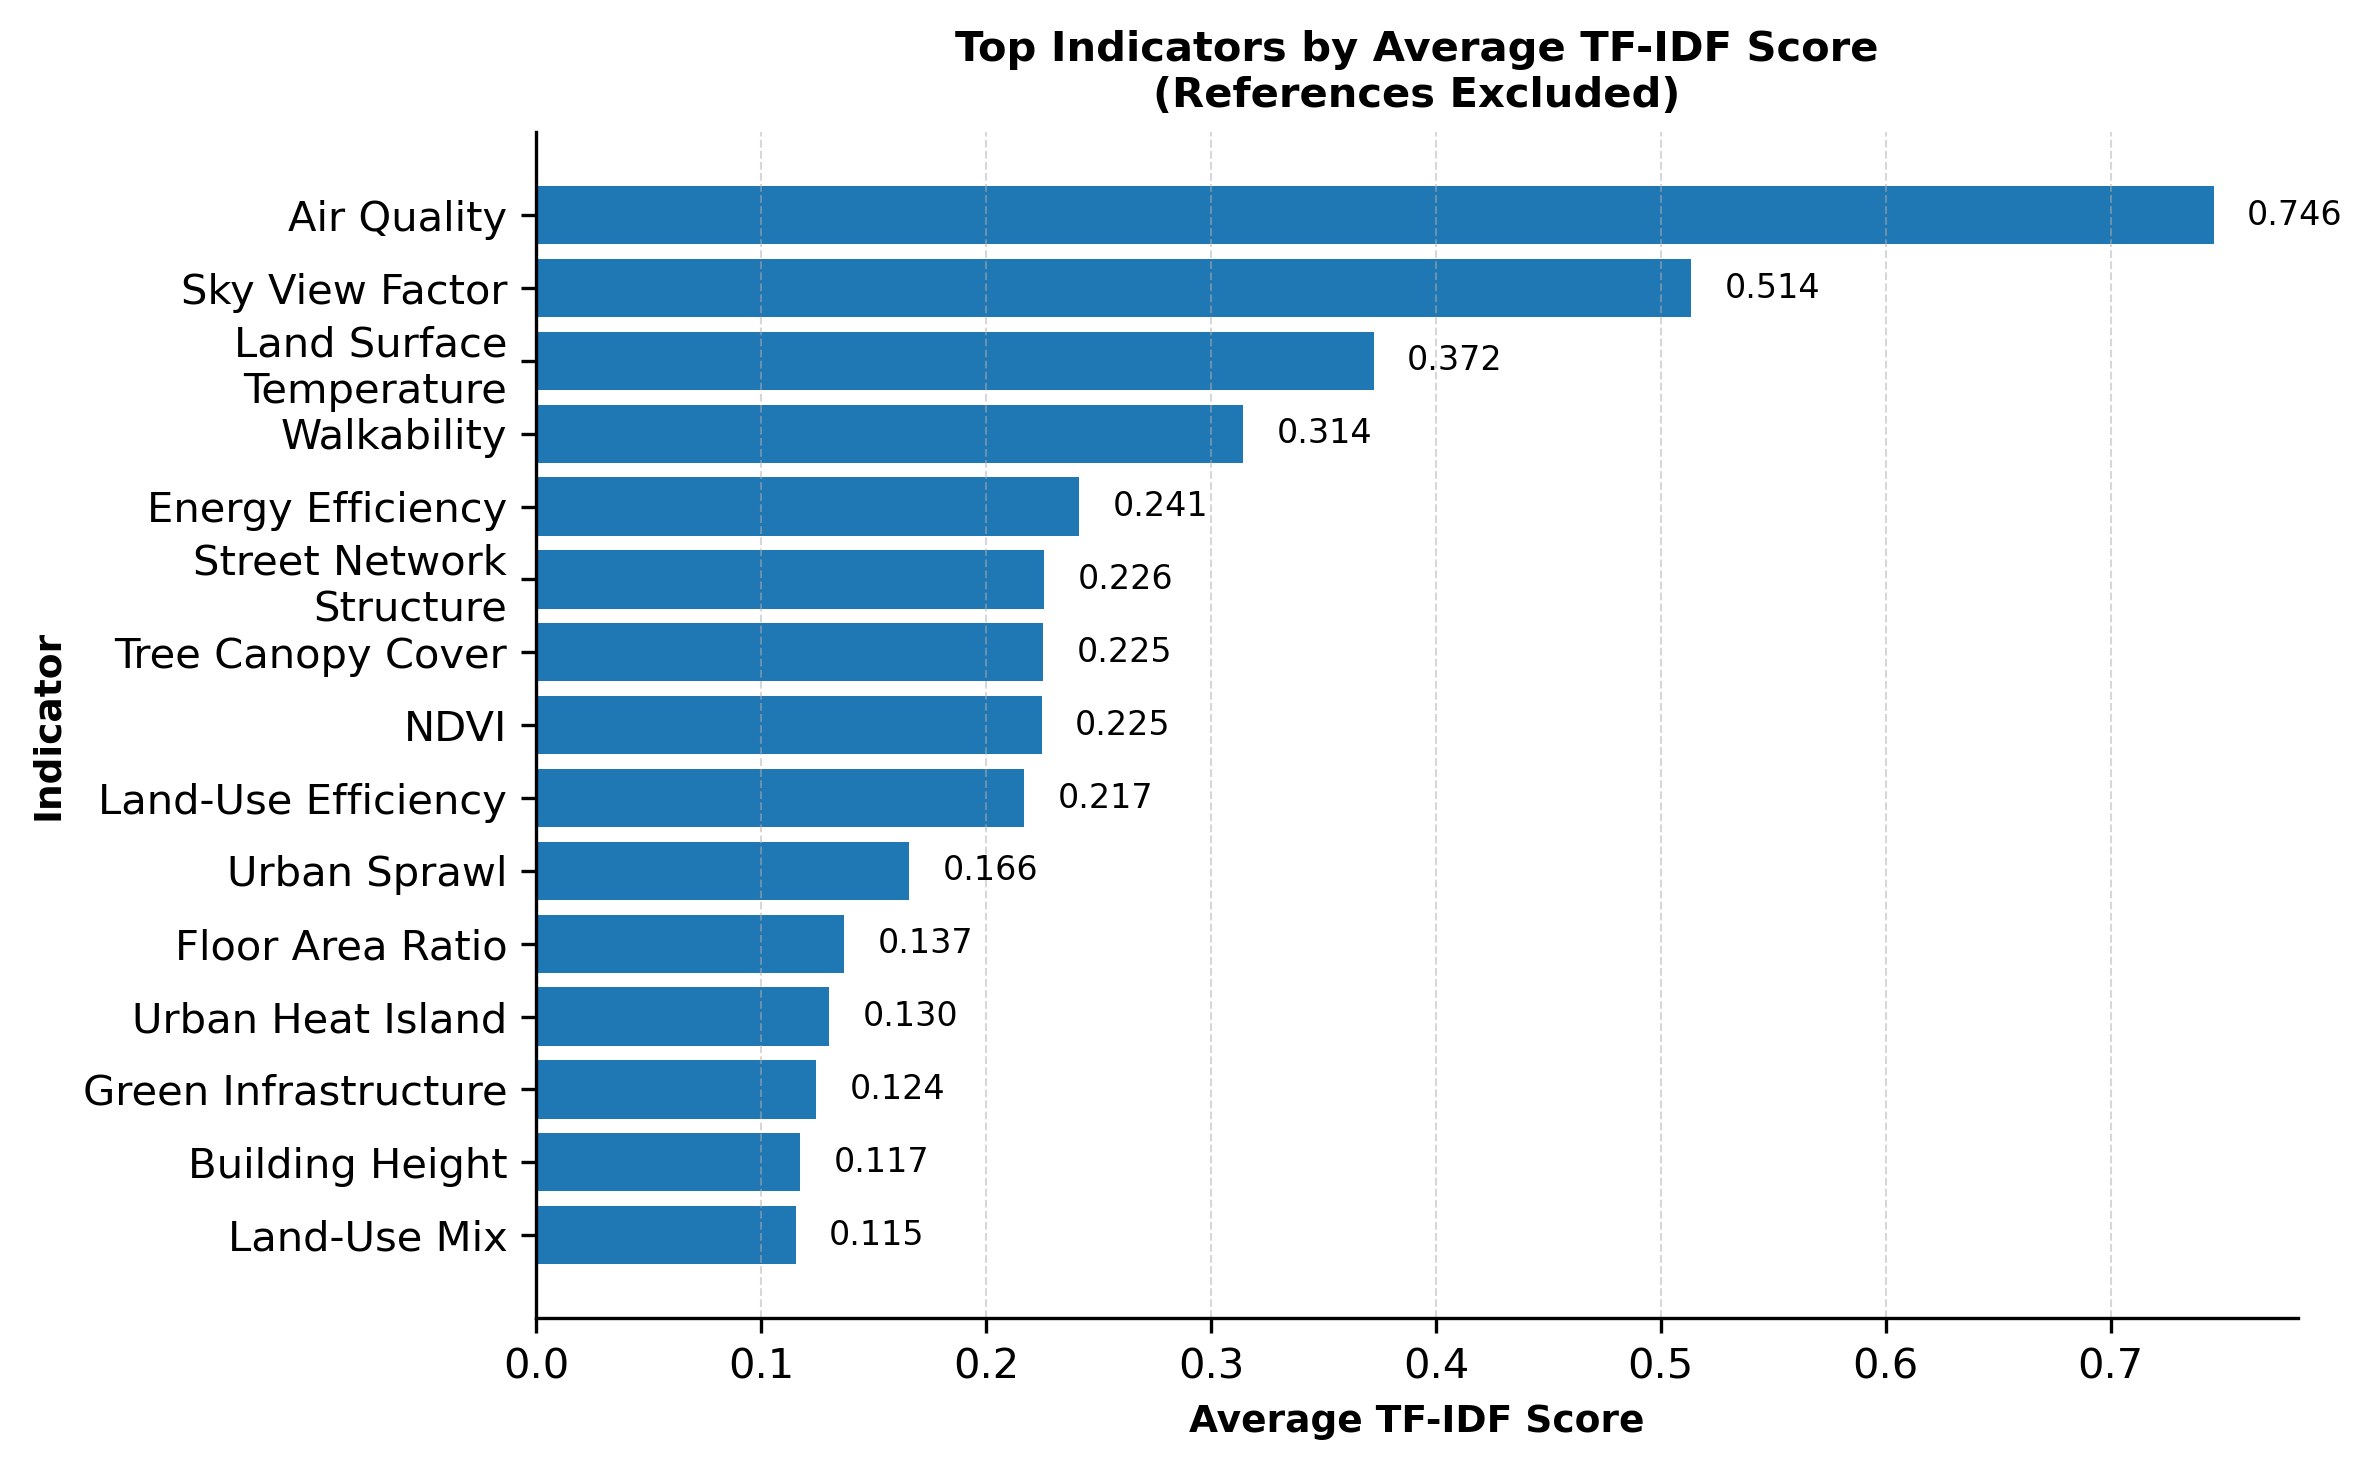

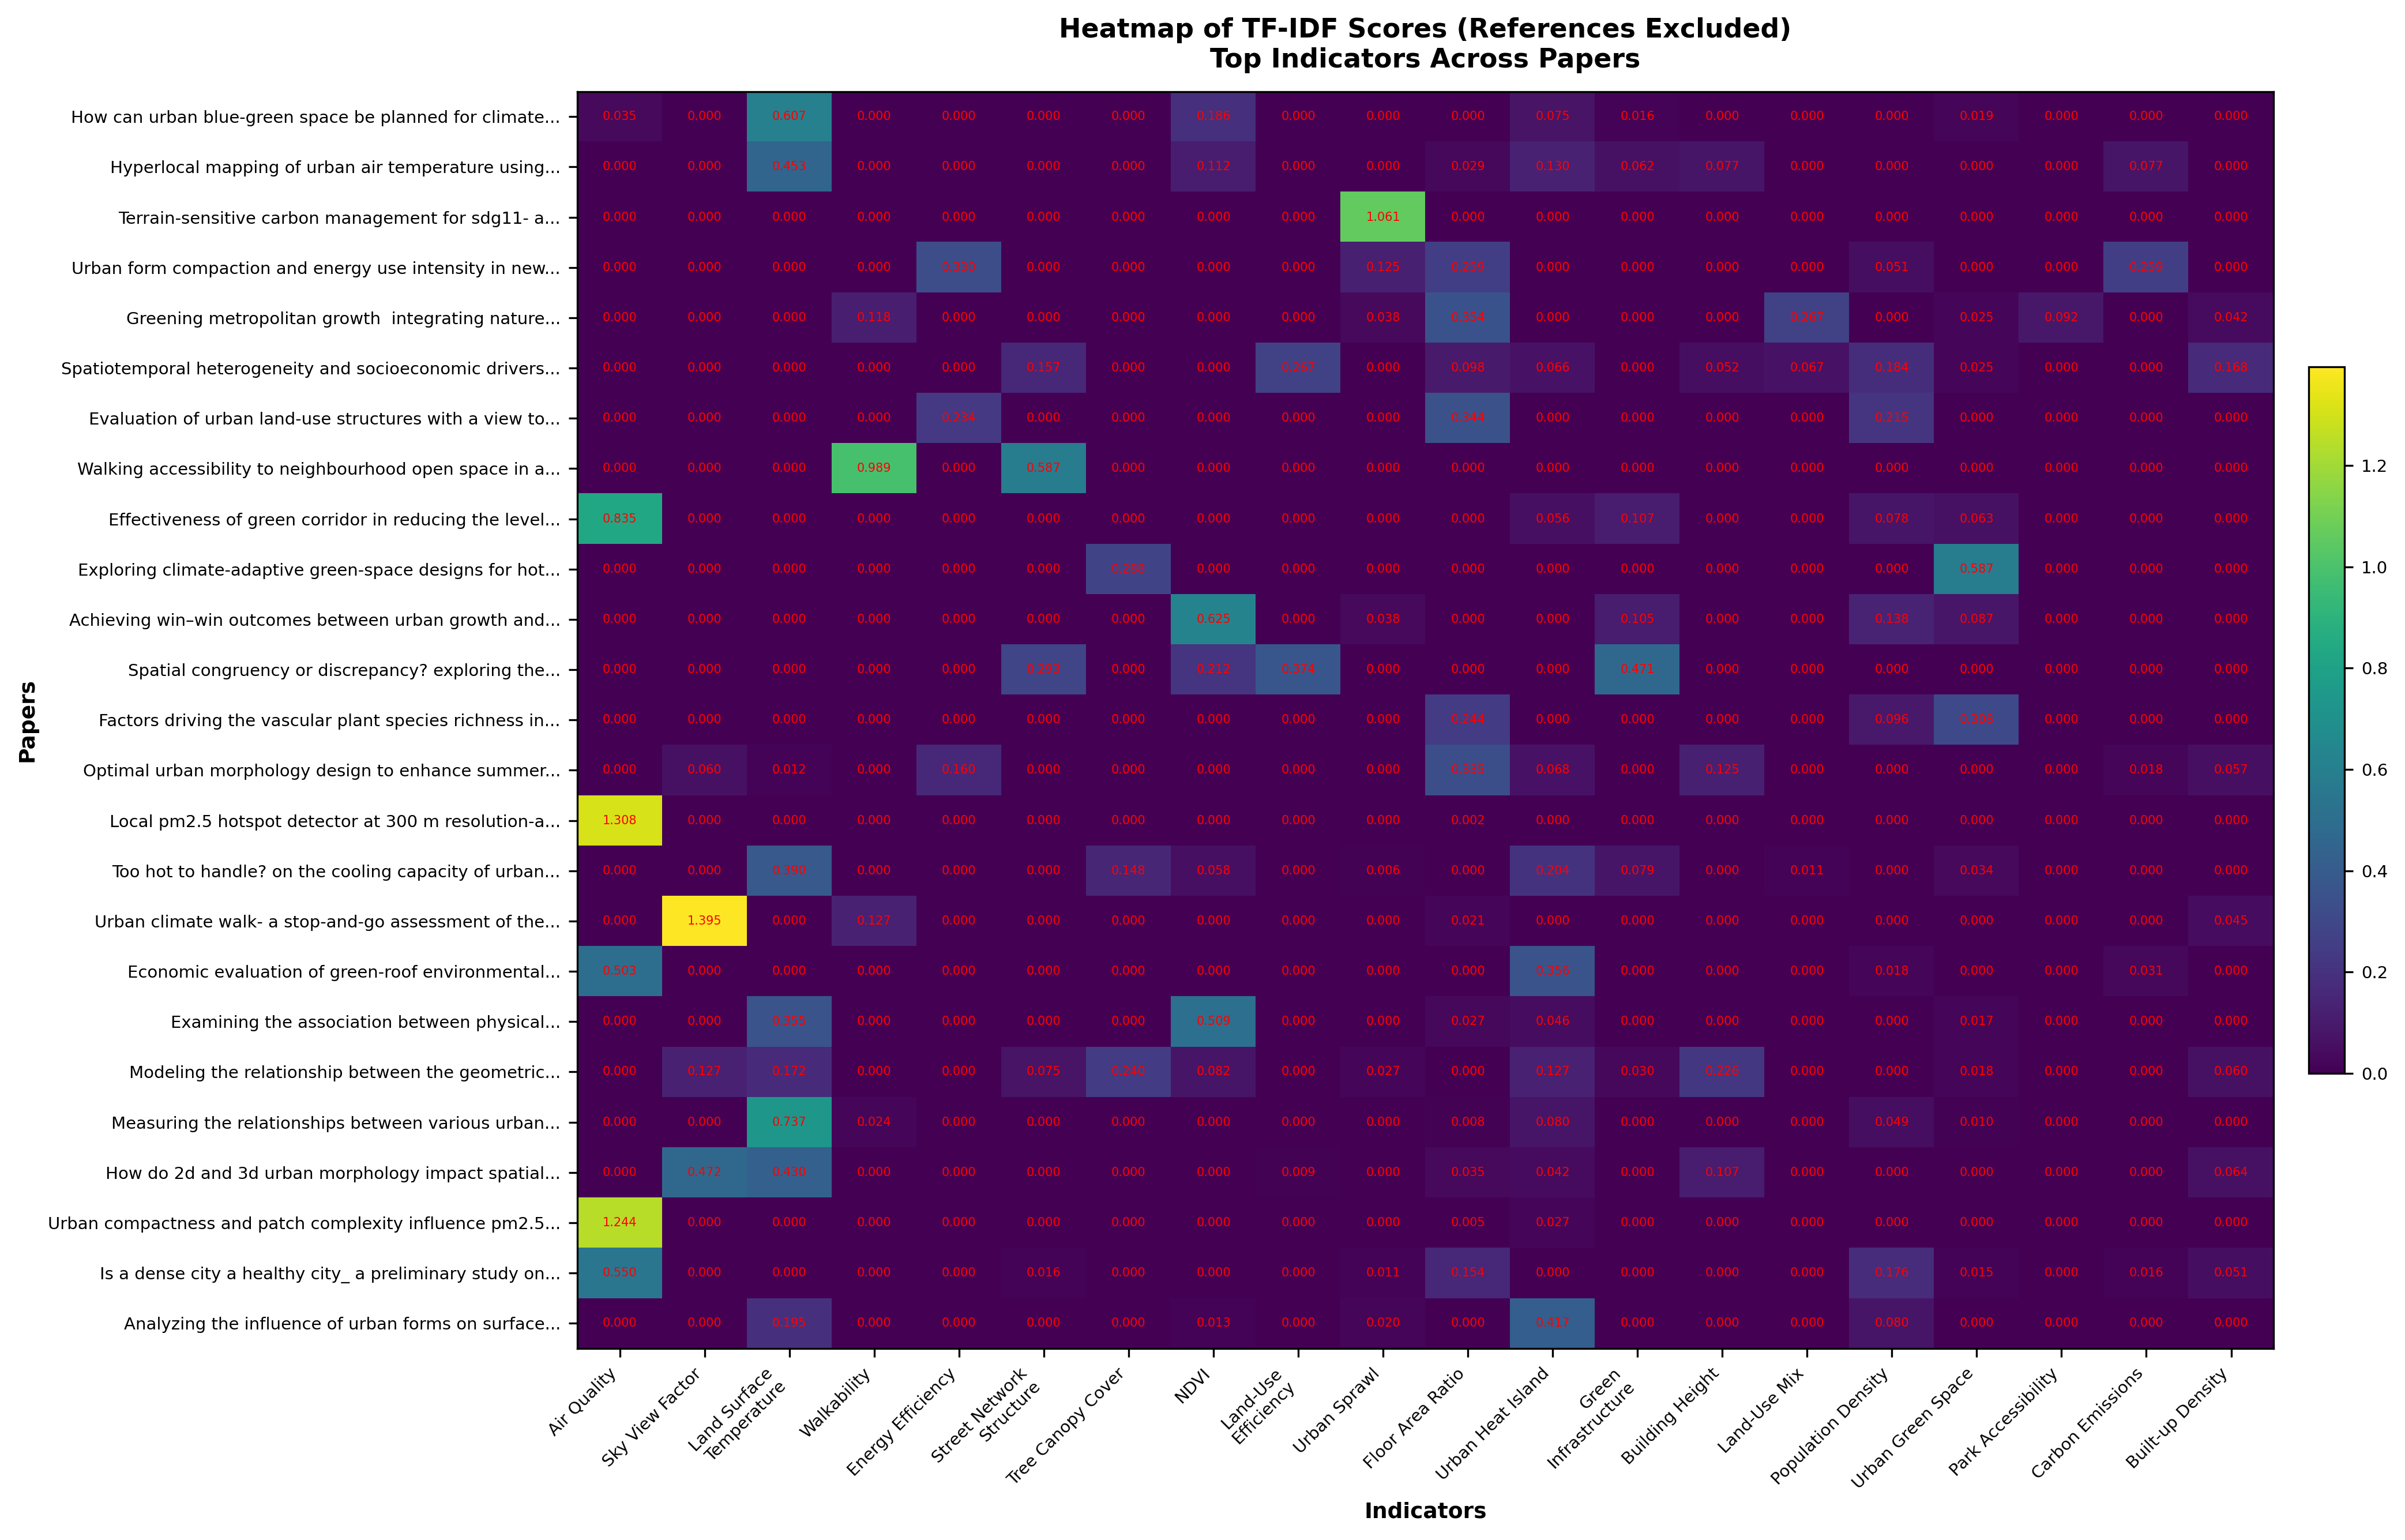


=== Aggregated TF-IDF by Dimension (5 Dimensions, no Ref) ===
                             Dimension  Indicator Count  Weighted TF-IDF
0  Climate & Environmental Performance                5         1.569889
1                   Morphology–Density                7         1.337385
2          Green & Blue Infrastructure                5         0.766592
3  Land-Use Mix & Functional Diversity                2         0.331978
4               Mobility–Accessibility                1         0.314332


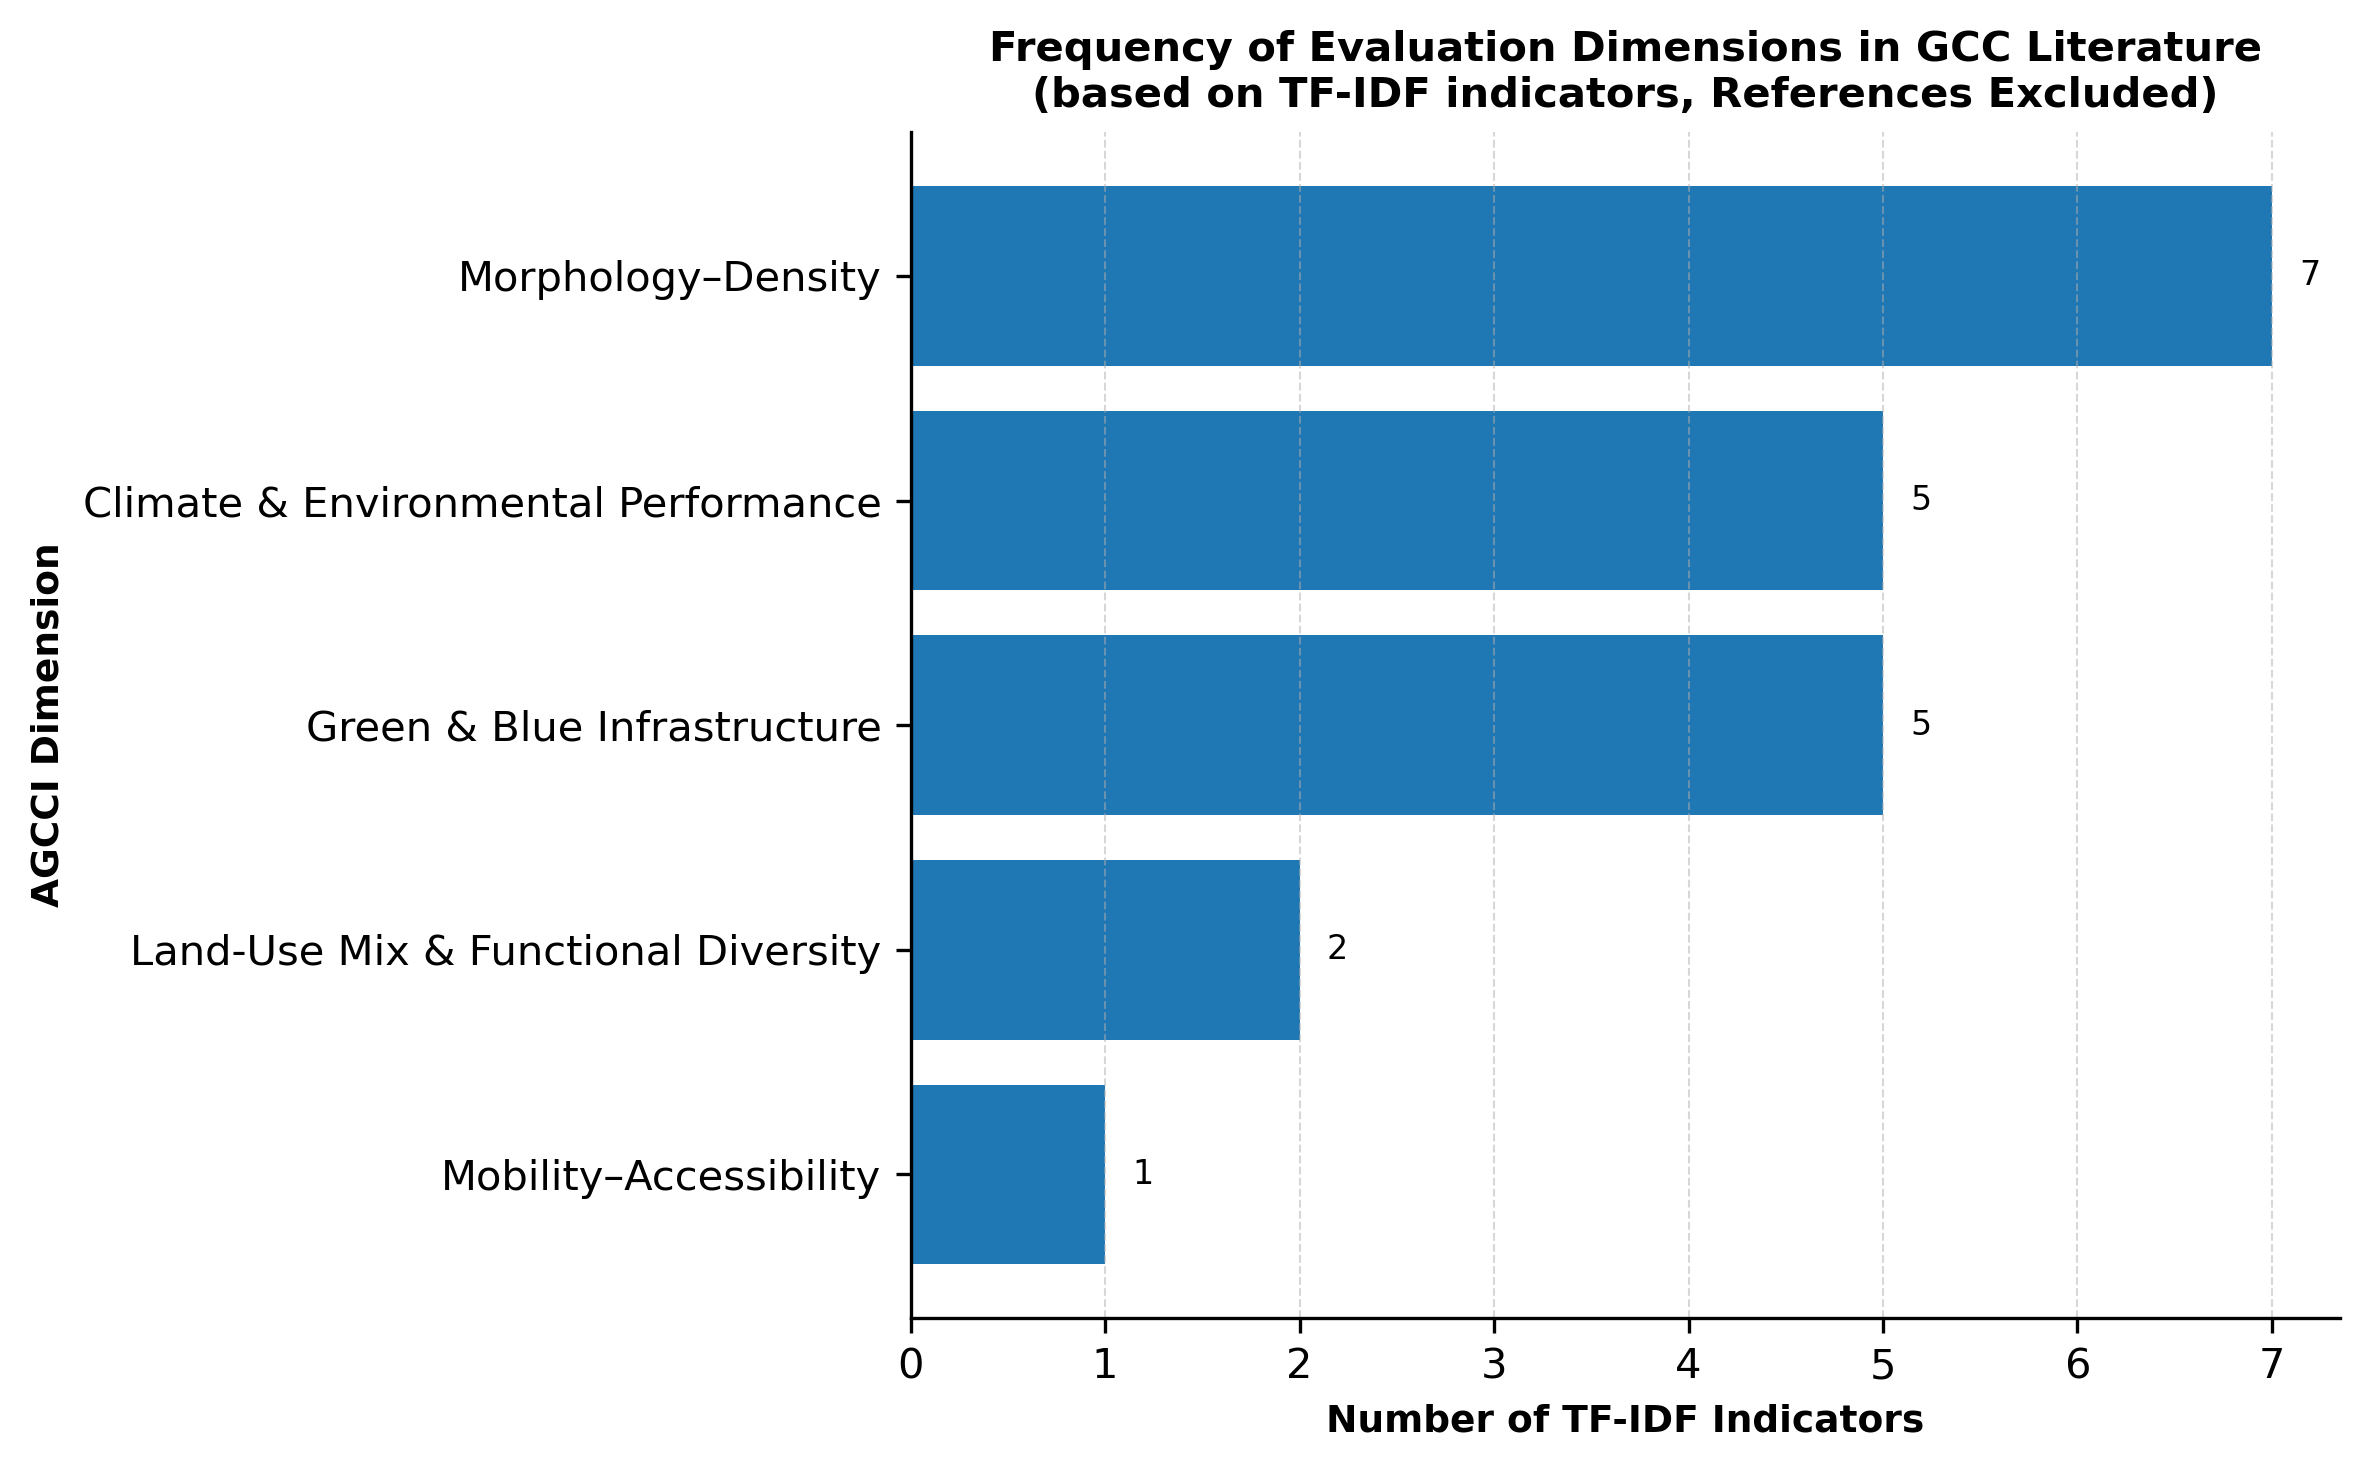


Excel saved → tfidf_indicators_by_dimension_noRef.xlsx


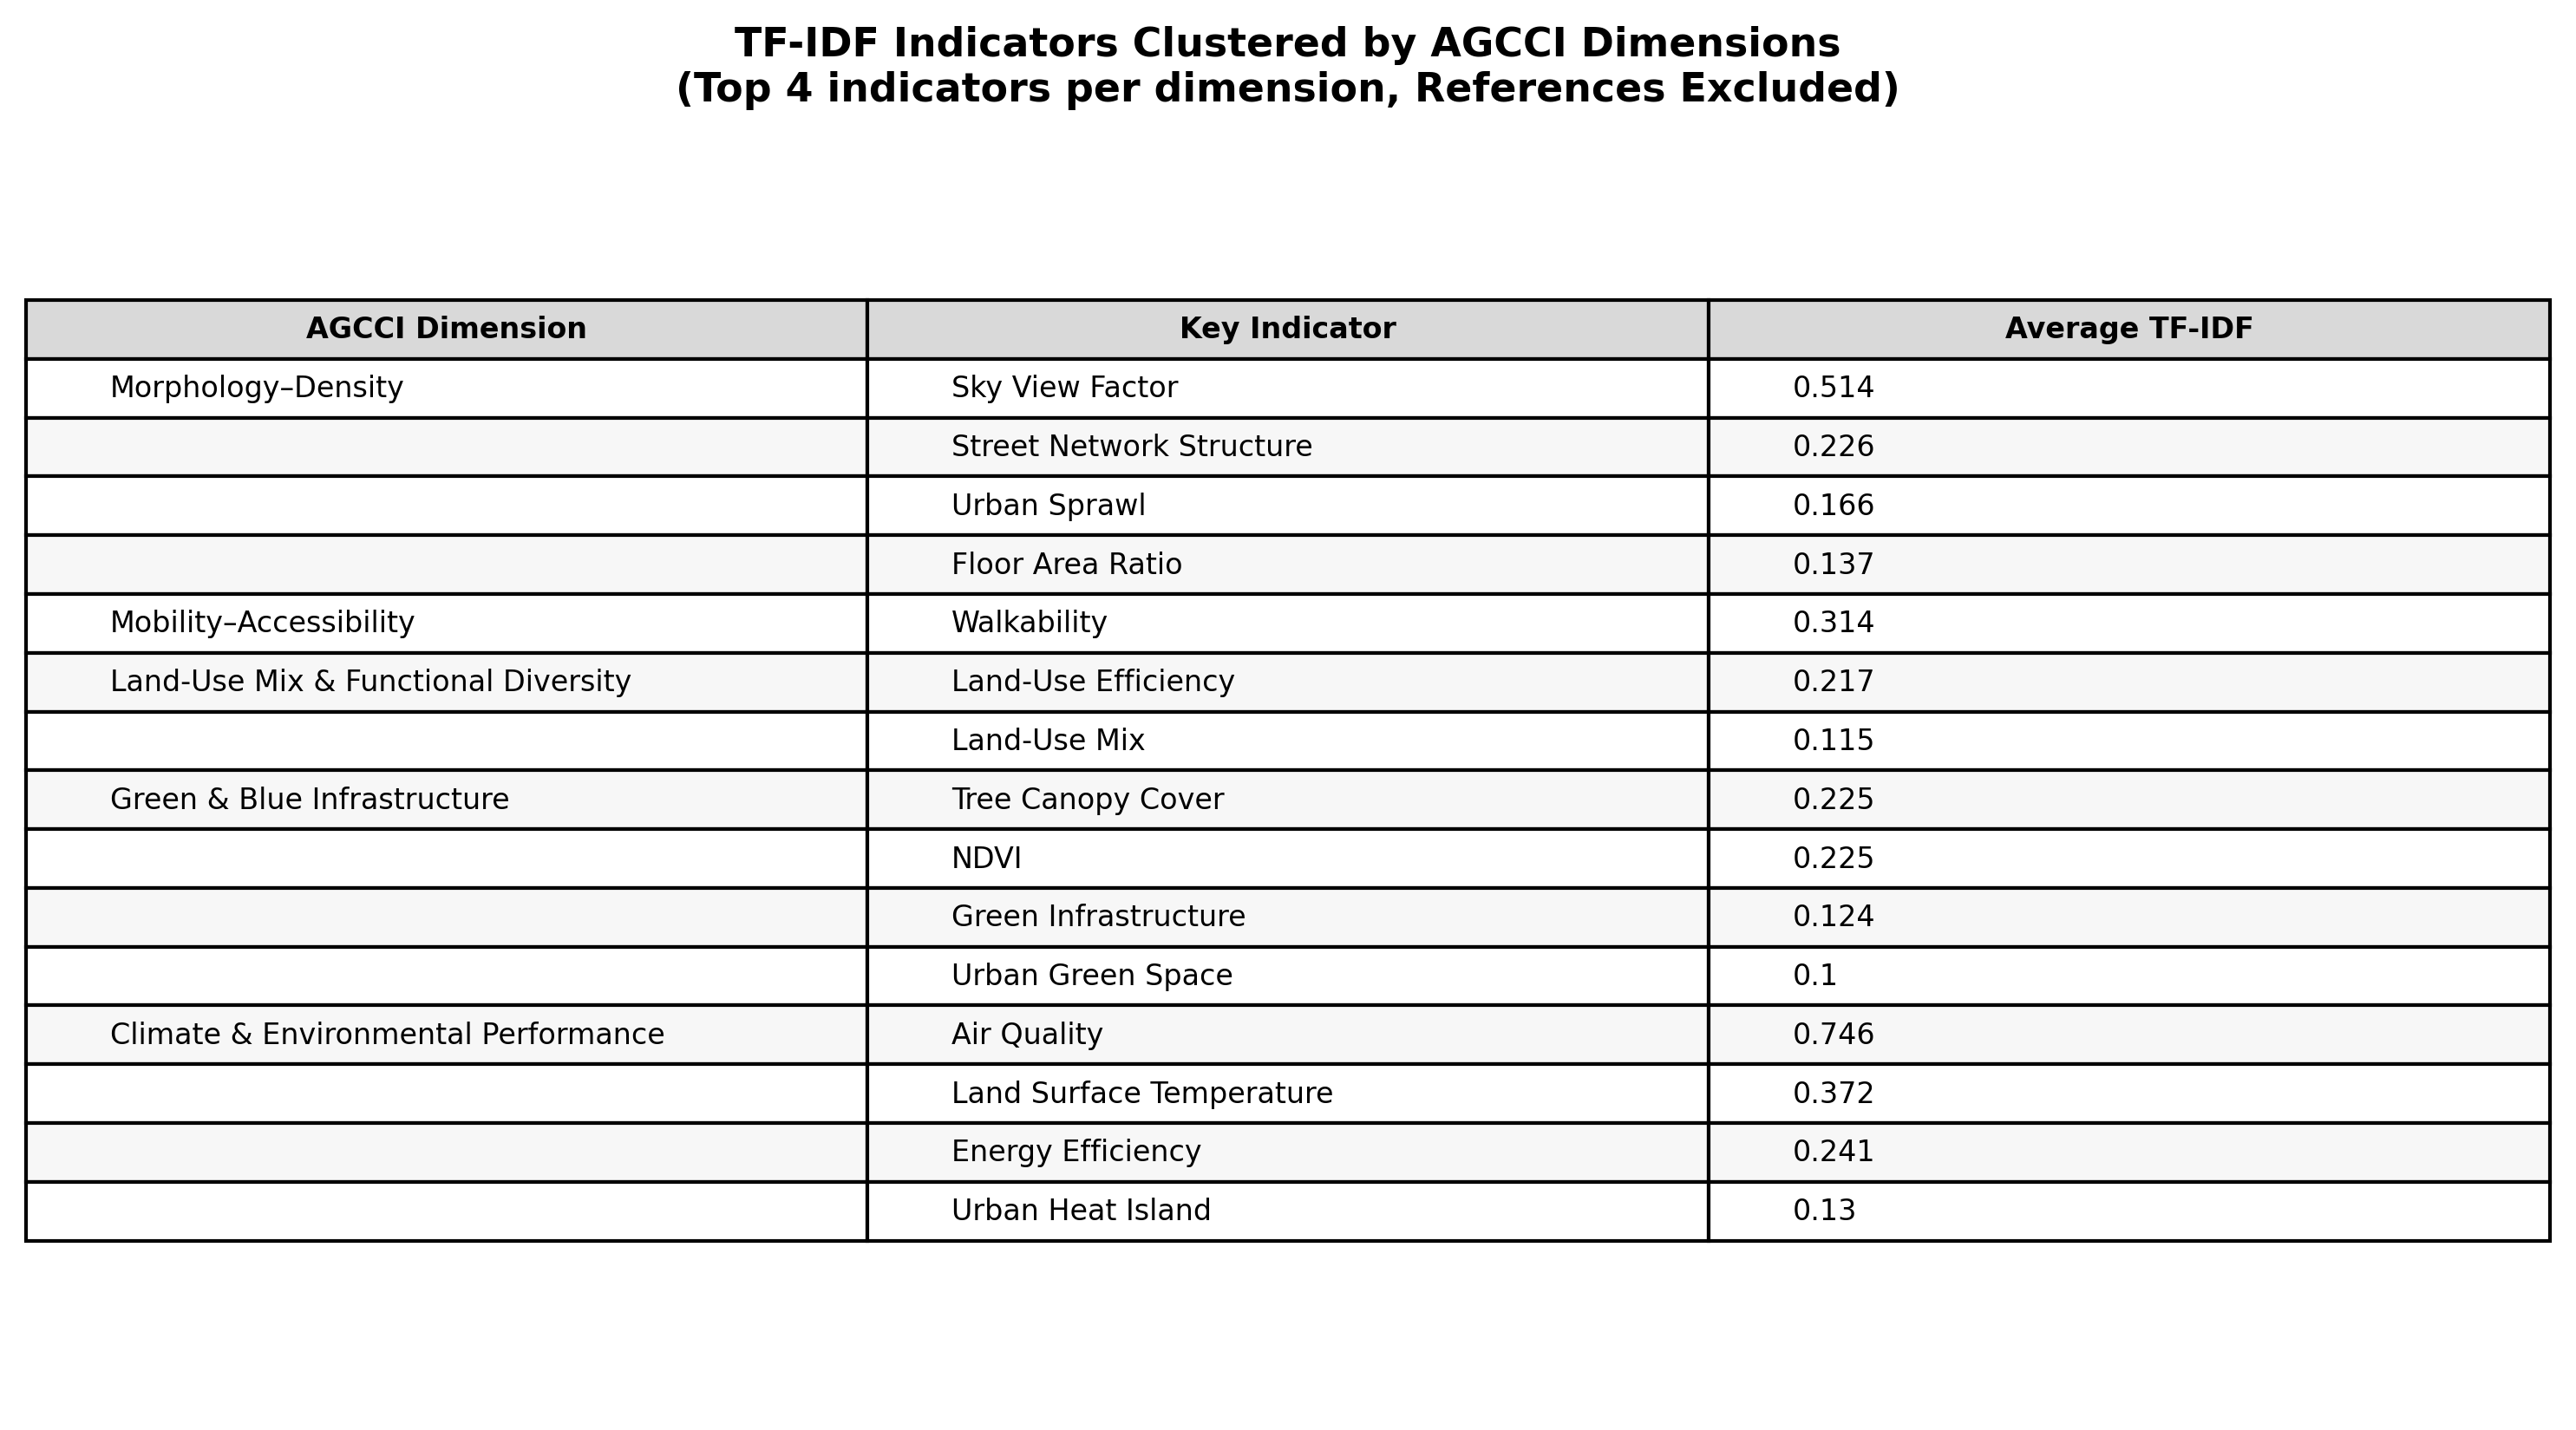


Figure saved → tfidf_indicators_by_dimension_table_noRef.png

TF-IDF analysis (References Excluded, Table A2) complete.


In [1]:
# ===============================================================
#   FULL PIPELINE (REVISED): TF-IDF + AGCCI (5 DIMENSIONS) + JOURNAL TABLE
#   BASED ON Appendix A (Table A2) INDICATOR DICTIONARY
#   - Full text PDF extraction (PyMuPDF)
#   - References section removed (heuristic)
#   - Indicator detection uses Table A2 keywords (code-level matching)
#   - Analysis uses codes internally; VISUALS show ONLY canonical names (no codes)
# ===============================================================

import os
import re
import textwrap
from collections import Counter

import fitz  # PyMuPDF
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ==========================================================
# 0) INDICATOR DICTIONARY (Appendix A - Table A2)
# - Keep codes for reproducibility
# - Use canonical + dimension for reporting
# ==========================================================

INDICATORS = {
    # (1) Morphology–Density
    "MOR_DEN": {
        "canonical": "Population Density",
        "dimension": "Morphology–Density",
        "ontology": "Metric",
        "keywords": ["population density", "inhabitants per hectare"],
    },
    "MOR_FAR": {
        "canonical": "Floor Area Ratio",
        "dimension": "Morphology–Density",
        "ontology": "Metric",
        "keywords": ["floor area ratio", "FAR", "plot ratio", "FSI"],
    },
    "MOR_BU": {
        "canonical": "Built-up Density",
        "dimension": "Morphology–Density",
        "ontology": "Metric",
        "keywords": ["built-up density", "building density"],
    },
    "MOR_HGT": {
        "canonical": "Building Height",
        "dimension": "Morphology–Density",
        "ontology": "Metric",
        "keywords": ["building height", "building storeys", "number of storeys"],
    },
    "MOR_COV": {
        "canonical": "Site Coverage",
        "dimension": "Morphology–Density",
        "ontology": "Metric",
        "keywords": ["site coverage", "building coverage ratio"],
    },
    "MOR_BLK": {
        "canonical": "Block Size",
        "dimension": "Morphology–Density",
        "ontology": "Metric",
        "keywords": ["block size", "urban block dimension"],
    },
    "MOR_NET": {
        "canonical": "Street Network Structure",
        "dimension": "Morphology–Density",
        "ontology": "Component",
        "keywords": ["street network", "road network"],
    },
    "MOR_SVF": {
        "canonical": "Sky View Factor",
        "dimension": "Morphology–Density",
        "ontology": "Metric",
        "keywords": ["sky view factor", "SVF"],
    },
    "MOR_SPL": {
        "canonical": "Urban Sprawl",
        "dimension": "Morphology–Density",
        "ontology": "Metric",
        "keywords": ["urban sprawl", "suburban sprawl"],
    },

    # (2) Mobility–Accessibility
    "MOB_WLK": {
        "canonical": "Walkability",
        "dimension": "Mobility–Accessibility",
        "ontology": "Metric",
        "keywords": ["walkability", "walk score"],
    },
    "MOB_BIK": {
        "canonical": "Bicycle Accessibility",
        "dimension": "Mobility–Accessibility",
        "ontology": "Metric",
        "keywords": ["bike accessibility", "cyclability"],
    },
    "MOB_PUB": {
        "canonical": "Public Transport Accessibility",
        "dimension": "Mobility–Accessibility",
        "ontology": "Metric",
        "keywords": ["public transit access", "transit accessibility"],
    },
    "MOB_CON": {
        "canonical": "Street Connectivity",
        "dimension": "Mobility–Accessibility",
        "ontology": "Metric",
        "keywords": ["street connectivity", "intersection density"],
    },
    "MOB_CTH": {
        "canonical": "Pedestrian Catchment Area",
        "dimension": "Mobility–Accessibility",
        "ontology": "Metric",
        "keywords": ["pedestrian catchment area", "pedestrian shed"],
    },
    "MOB_MOD": {
        "canonical": "Modal Split",
        "dimension": "Mobility–Accessibility",
        "ontology": "Metric",
        "keywords": ["modal split", "mode share"],
    },
    "MOB_TOD": {
        "canonical": "Transit-Oriented Development",
        "dimension": "Mobility–Accessibility",
        "ontology": "System",
        "keywords": ["transit-oriented development", "TOD"],
    },

    # (3) Land-Use Mix & Functional Diversity
    "LUM_MIX": {
        "canonical": "Land-Use Mix",
        "dimension": "Land-Use Mix & Functional Diversity",
        "ontology": "Metric",
        "keywords": ["land-use mix", "mixed land use"],
    },
    "LUM_ENT": {
        "canonical": "Entropy Index",
        "dimension": "Land-Use Mix & Functional Diversity",
        "ontology": "Metric",
        "keywords": ["entropy index", "land-use entropy"],
    },
    "LUM_JOB": {
        "canonical": "Jobs–Housing Balance",
        "dimension": "Land-Use Mix & Functional Diversity",
        "ontology": "Metric",
        "keywords": ["jobs–housing balance", "jobs-housing balance"],
    },
    "LUM_EFF": {
        "canonical": "Land-Use Efficiency",
        "dimension": "Land-Use Mix & Functional Diversity",
        "ontology": "Metric",
        "keywords": ["land-use efficiency", "land use efficiency"],
    },

    # (4) Green & Blue Infrastructure
    "GBI_SYS": {
        "canonical": "Green Infrastructure",
        "dimension": "Green & Blue Infrastructure",
        "ontology": "System",
        "keywords": ["green infrastructure", "green-blue infrastructure"],
    },
    "GBI_UGS": {
        "canonical": "Urban Green Space",
        "dimension": "Green & Blue Infrastructure",
        "ontology": "Component",
        "keywords": ["urban green space", "urban parks", "urban greenery"],
    },
    "GBI_CAN": {
        "canonical": "Tree Canopy Cover",
        "dimension": "Green & Blue Infrastructure",
        "ontology": "Metric",
        "keywords": ["tree canopy cover", "tree cover"],
    },
    "GBI_NDV": {
        "canonical": "NDVI",
        "dimension": "Green & Blue Infrastructure",
        "ontology": "Metric",
        "keywords": ["NDVI", "normalized difference vegetation index"],
    },
    "GBI_ACC": {
        "canonical": "Park Accessibility",
        "dimension": "Green & Blue Infrastructure",
        "ontology": "Metric",
        "keywords": ["park accessibility", "access to parks"],
    },
    "GBI_PER": {
        "canonical": "Permeable Surface Ratio",
        "dimension": "Green & Blue Infrastructure",
        "ontology": "Metric",
        "keywords": ["permeable surface ratio"],
    },
    "GBI_SUD": {
        "canonical": "Sustainable Urban Drainage Systems",
        "dimension": "Green & Blue Infrastructure",
        "ontology": "System",
        "keywords": ["SUDS", "sustainable urban drainage", "LID"],
    },

    # (5) Climate & Environmental Performance
    "CLM_UHI": {
        "canonical": "Urban Heat Island",
        "dimension": "Climate & Environmental Performance",
        "ontology": "Outcome Metric",
        "keywords": ["urban heat island", "UHI", "SUHI"],
    },
    "CLM_LST": {
        "canonical": "Land Surface Temperature",
        "dimension": "Climate & Environmental Performance",
        "ontology": "Outcome Metric",
        "keywords": ["land surface temperature", "LST"],
    },
    "CLM_AIR": {
        "canonical": "Air Quality",
        "dimension": "Climate & Environmental Performance",
        "ontology": "Outcome Metric",
        "keywords": ["air quality", "PM2.5", "NO2", "NO₂"],
    },
    "CLM_ENG": {
        "canonical": "Energy Efficiency",
        "dimension": "Climate & Environmental Performance",
        "ontology": "Outcome Metric",
        "keywords": ["energy efficiency", "energy use intensity"],
    },
    "CLM_CAR": {
        "canonical": "Carbon Emissions",
        "dimension": "Climate & Environmental Performance",
        "ontology": "Outcome Metric",
        "keywords": ["carbon emissions", "CO2 emissions", "CO₂ emissions"],
    },
}

# For stable ordering in tables/plots
DIMENSION_ORDER = [
    "Morphology–Density",
    "Mobility–Accessibility",
    "Land-Use Mix & Functional Diversity",
    "Green & Blue Infrastructure",
    "Climate & Environmental Performance",
]


# ==========================================================
# 1) Helpers
# ==========================================================
def normalize_text(s: str) -> str:
    if not s:
        return ""
    s = s.lower()
    s = (s.replace("no₂", "no2")
           .replace("co₂", "co2")
           .replace("pm₂.₅", "pm2.5")
           .replace("–", "-")
           .replace("—", "-"))
    s = re.sub(r"\s+", " ", s).strip()
    return s


def strip_references(full_text: str) -> str:
    """
    Remove references section at the end using heuristic markers.
    """
    text_lower = normalize_text(full_text)
    patterns = [
        r"\breferences\b",
        r"\bbibliography\b",
        r"\bworks cited\b",
        r"\breferences and notes\b",
        r"\bdaftar pustaka\b",
        r"\brujukan\b",
        r"참고문헌",
    ]
    cut_pos = None
    for pat in patterns:
        m = re.search(pat, text_lower)
        if m:
            cut_pos = m.start()
            break
    return full_text[:cut_pos] if cut_pos is not None else full_text


def to_sentence_case(text: str) -> str:
    text = (text or "").strip()
    if not text:
        return text
    t = text.lower()
    return t[0].upper() + t[1:]


def _kw_to_regex(kw: str) -> str:
    """
    Convert keyword to regex with word-boundaries where safe.
    """
    kw_norm = normalize_text(kw)
    escaped = re.escape(kw_norm)
    if re.fullmatch(r"[a-z0-9 \-\.]+", kw_norm):
        return r"\b" + escaped + r"\b"
    return escaped


def compile_indicator_patterns(indicators: dict) -> dict:
    compiled = {}
    for code, meta in indicators.items():
        pats = [_kw_to_regex(k) for k in meta["keywords"]]
        compiled[code] = re.compile("(" + "|".join(pats) + ")", flags=re.IGNORECASE)
    return compiled


INDICATOR_PATTERNS = compile_indicator_patterns(INDICATORS)


# ==========================================================
# 2) PDF Text Extraction
# ==========================================================
def extract_text_from_pdf(pdf_path: str) -> str:
    try:
        with fitz.open(pdf_path) as doc:
            return "\n".join([p.get_text("text") for p in doc])
    except Exception as e:
        print(f"Error reading {pdf_path}: {e}")
        return ""


# ==========================================================
# 3) TF (term counts) per document (References excluded)
# - Counts are computed at CODE level (Appendix A Table A2)
# ==========================================================
def analyze_for_tfidf(pdf_folder: str) -> dict:
    """
    Returns:
        indicator_counts_per_doc: {filename: Counter({code: count, ...}), ...}
    """
    pdf_files = [f for f in os.listdir(pdf_folder) if f.lower().endswith(".pdf")]
    print(f"Found {len(pdf_files)} PDF files to process for TF-IDF.")

    indicator_counts_per_doc = {}

    for filename in pdf_files:
        print(f"--- Processing {filename} ---")
        file_path = os.path.join(pdf_folder, filename)

        full_text = extract_text_from_pdf(file_path)
        if not full_text:
            continue

        main_text = strip_references(full_text)
        text_lower = normalize_text(main_text)

        doc_counts = Counter()

        # Count matches for each indicator code
        for code, rx in INDICATOR_PATTERNS.items():
            matches = rx.findall(text_lower)
            if matches:
                doc_counts[code] += len(matches)

        if doc_counts:
            indicator_counts_per_doc[filename] = doc_counts

    return indicator_counts_per_doc


# ==========================================================
# 4) TF-IDF computation + outputs (Top 15 + Heatmap)
# - Reporting uses canonical indicator names only
# ==========================================================
def calculate_and_analyze_tfidf(indicator_counts_per_doc: dict,
                               top_bar_n: int = 15,
                               heatmap_top_n: int = 30):
    total_docs = len(indicator_counts_per_doc)
    if total_docs == 0:
        print("No documents to analyze for TF-IDF.")
        return [], {}, {}

    # Document frequency (DF)
    df_counter = Counter()
    for doc_counts in indicator_counts_per_doc.values():
        for code in doc_counts.keys():
            df_counter[code] += 1

    # IDF (smoothed)
    idf = {code: np.log((total_docs + 1) / (df + 1)) for code, df in df_counter.items()}

    # TF-IDF per document
    tfidf_scores_per_doc = {}
    for doc_name, doc_counts in indicator_counts_per_doc.items():
        tfidf_scores_per_doc[doc_name] = {}
        total_terms = sum(doc_counts.values())
        if total_terms == 0:
            continue
        for code, cnt in doc_counts.items():
            tf = cnt / total_terms
            tfidf_scores_per_doc[doc_name][code] = tf * idf.get(code, 0.0)

    # Average TF-IDF per indicator code
    avg_collect = {}
    for doc_scores in tfidf_scores_per_doc.values():
        for code, sc in doc_scores.items():
            avg_collect.setdefault(code, []).append(sc)

    avg_tfidf = {code: float(np.mean(scores)) for code, scores in avg_collect.items()}
    sorted_codes = sorted(avg_tfidf.items(), key=lambda x: x[1], reverse=True)

    # Pretty print
    print("\n" + "=" * 80)
    print("TF-IDF Analysis (References Excluded): Top Indicators (Table A2)")
    print("=" * 80)
    for code, score in sorted_codes[:top_bar_n]:
        cname = INDICATORS[code]["canonical"]
        dim = INDICATORS[code]["dimension"]
        print(f"{cname:<35} | {dim:<40}: {score:.4f}")

    # -------------------------
    # VIS 1: Bar chart (Top N)
    # -------------------------
    top_items = sorted_codes[:top_bar_n]
    labels = [INDICATORS[c]["canonical"] for c, _ in top_items]  # no codes
    values = [v for _, v in top_items]

    wrapped = ["\n".join(textwrap.wrap(lab, width=22)) for lab in labels]

    fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")

    bars = ax.barh(wrapped, values)
    ax.invert_yaxis()

    ax.set_title("Top Indicators by Average TF-IDF Score\n(References Excluded)",
                 fontsize=10, fontweight="bold")
    ax.set_xlabel("Average TF-IDF Score", fontsize=9, fontweight="bold")
    ax.set_ylabel("Indicator", fontsize=9, fontweight="bold")

    ax.xaxis.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
    ax.yaxis.grid(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    vmax = max(values) if values else 1
    for bar, val in zip(bars, values):
        ax.text(bar.get_width() + vmax * 0.02,
                bar.get_y() + bar.get_height() / 2,
                f"{val:.3f}",
                va="center", ha="left", fontsize=8)

    plt.tight_layout()
    plt.savefig("top_indicators_tfidf_noRef.png", dpi=300, bbox_inches="tight", facecolor="white")
    plt.show()

    # -------------------------
    # VIS 2: Heatmap (Top N)
    #   - Matplotlib-only (no seaborn dependency)
    # -------------------------
    top_codes_hm = [c for c, _ in sorted_codes[:heatmap_top_n]]

    rows = []
    row_names = []
    for doc_name, sc_map in tfidf_scores_per_doc.items():
        row = [sc_map.get(c, 0.0) for c in top_codes_hm]
        if sum(row) > 0:
            rows.append(row)
            row_names.append(doc_name)

    if rows:
        mat = np.array(rows)
        col_names = [INDICATORS[c]["canonical"] for c in top_codes_hm]  # no codes

        # Clean paper names
        cleaned = []
        for nm in row_names:
            base = os.path.splitext(nm)[0]
            base = re.sub(r"^\s*\d+\.\s*", "", base)
            base = to_sentence_case(base)
            if len(base) > 55:
                cut = base[:55]
                if " " in cut:
                    cut = cut.rsplit(" ", 1)[0]
                base = cut + "..."
            cleaned.append(base)

        fig, ax = plt.subplots(figsize=(14, 9), dpi=300)
        fig.patch.set_facecolor("white")
        ax.set_facecolor("white")

        im = ax.imshow(mat, aspect="auto")
        cbar = plt.colorbar(im, ax=ax, fraction=0.02, pad=0.02)
        cbar.ax.tick_params(labelsize=7)

        ax.set_title("Heatmap of TF-IDF Scores (References Excluded)\nTop Indicators Across Papers",
                     fontsize=11, fontweight="bold", pad=10)
        ax.set_xlabel("Indicators", fontsize=9, fontweight="bold")
        ax.set_ylabel("Papers", fontsize=9, fontweight="bold")

        ax.set_xticks(np.arange(len(col_names)))
        ax.set_yticks(np.arange(len(cleaned)))

        ax.set_xticklabels([("\n".join(textwrap.wrap(c, 18))) for c in col_names],
                           rotation=45, ha="right", fontsize=7)
        ax.set_yticklabels(cleaned, fontsize=7)

        # Optional annotation (can be heavy if too many cells)
        # Annotate only if matrix not too large
        if mat.shape[0] * mat.shape[1] <= 900:
            for i in range(mat.shape[0]):
                for j in range(mat.shape[1]):
                    ax.text(j, i, f"{mat[i, j]:.3f}",
                            ha="center", va="center", fontsize=5, color="red")

        plt.tight_layout()
        plt.savefig("tfidf_heatmap_noRef.png", dpi=300, bbox_inches="tight", facecolor="white")
        plt.show()

    # Return for downstream aggregation
    return sorted_codes, tfidf_scores_per_doc, avg_tfidf


# ==========================================================
# 5) Aggregate TF-IDF by AGCCI dimensions (5D only, from Table A2)
# ==========================================================
def aggregate_by_dimension(sorted_tfidf_codes, indicators_dict=INDICATORS):
    """
    Input: [(code, avg_tfidf), ...]
    Output:
        dim_counts: {dim: n_indicators_present}
        dim_scores: {dim: sum(avg_tfidf)}
        unmatched:  list of codes not found in dict (should be none)
    """
    dim_counts = {d: 0 for d in DIMENSION_ORDER}
    dim_scores = {d: 0.0 for d in DIMENSION_ORDER}
    unmatched = []

    for code, score in sorted_tfidf_codes:
        meta = indicators_dict.get(code)
        if not meta:
            unmatched.append(code)
            continue
        dim = meta["dimension"]
        # Keep only the five dimensions we defined
        if dim not in dim_counts:
            dim_counts.setdefault(dim, 0)
            dim_scores.setdefault(dim, 0.0)
        dim_counts[dim] += 1
        dim_scores[dim] += float(score)

    return dim_counts, dim_scores, unmatched


def list_indicators_by_dimension(sorted_tfidf_codes, indicators_dict=INDICATORS):
    grouped = {d: [] for d in DIMENSION_ORDER}
    grouped["Unmatched"] = []

    for code, score in sorted_tfidf_codes:
        meta = indicators_dict.get(code)
        if not meta:
            grouped["Unmatched"].append((code, round(float(score), 4)))
            continue
        dim = meta["dimension"]
        cname = meta["canonical"]
        grouped.setdefault(dim, []).append((cname, round(float(score), 4)))

    # sort within dim
    for dim in grouped:
        grouped[dim] = sorted(grouped[dim], key=lambda x: x[1], reverse=True)

    return grouped


# ==========================================================
# 6) MAIN
# ==========================================================
if __name__ == "__main__":
    # Update to your folder path
    PDF_FOLDER = "/Users/dwiprabowo/Downloads/greencompactcityurban/25"

    print("\n===== Starting TF-IDF Analysis (References Excluded, Table A2) =====")
    counts_per_doc = analyze_for_tfidf(PDF_FOLDER)

    if not counts_per_doc:
        print("\nNo PDF indicators detected.")
        raise SystemExit

    # Compute TF-IDF + figures
    tfidf_sorted, tfidf_scores_per_doc, avg_tfidf = calculate_and_analyze_tfidf(counts_per_doc)

    # Aggregate by dimension
    dim_counts, dim_scores, unmatched_codes = aggregate_by_dimension(tfidf_sorted)

    dim_df = pd.DataFrame({
        "Dimension": list(dim_counts.keys()),
        "Indicator Count": list(dim_counts.values()),
        "Weighted TF-IDF": [dim_scores[d] for d in dim_counts.keys()],
    })

    # Sort for display (by Weighted TF-IDF)
    dim_df["Dimension"] = pd.Categorical(dim_df["Dimension"], categories=DIMENSION_ORDER, ordered=True)
    dim_df = dim_df.sort_values("Weighted TF-IDF", ascending=False).reset_index(drop=True)

    print("\n=== Aggregated TF-IDF by Dimension (5 Dimensions, no Ref) ===")
    print(dim_df)

    # Dimension frequency chart
    dim_df_sorted = dim_df.sort_values(by="Indicator Count", ascending=False)

    fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")

    bars = ax.barh(dim_df_sorted["Dimension"], dim_df_sorted["Indicator Count"])
    ax.invert_yaxis()

    ax.set_title(
        "Frequency of Evaluation Dimensions in GCC Literature\n"
        "(based on TF-IDF indicators, References Excluded)",
        fontsize=10, fontweight="bold"
    )
    ax.set_xlabel("Number of TF-IDF Indicators", fontsize=9, fontweight="bold")
    ax.set_ylabel("AGCCI Dimension", fontsize=9, fontweight="bold")

    ax.xaxis.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
    ax.yaxis.grid(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    max_val = dim_df_sorted["Indicator Count"].max() if len(dim_df_sorted) else 1
    for bar, val in zip(bars, dim_df_sorted["Indicator Count"]):
        ax.text(bar.get_width() + max_val * 0.02,
                bar.get_y() + bar.get_height() / 2,
                f"{int(val)}",
                va="center", ha="left", fontsize=8)

    plt.tight_layout()
    plt.savefig("dimension_frequency_from_tfidf_noRef.png", dpi=300, bbox_inches="tight", facecolor="white")
    plt.show()

    # List indicators by dimension (canonical only)
    grouped = list_indicators_by_dimension(tfidf_sorted)

    rows = []
    for dim, items in grouped.items():
        if dim == "Unmatched":
            continue
        for cname, score in items:
            rows.append({"Dimension": dim, "Indicator": cname, "Avg TF-IDF Score": score})

    df_dim_ind = pd.DataFrame(rows)
    df_dim_ind["Dimension"] = pd.Categorical(df_dim_ind["Dimension"], categories=DIMENSION_ORDER, ordered=True)
    df_dim_ind = df_dim_ind.sort_values(["Dimension", "Avg TF-IDF Score"], ascending=[True, False]).reset_index(drop=True)

    df_dim_ind.to_excel("tfidf_indicators_by_dimension_noRef.xlsx", index=False)
    print("\nExcel saved → tfidf_indicators_by_dimension_noRef.xlsx")

    # Journal-style table figure: top N indicators per dimension
    top_n_per_dim = 4
    df_fig = (
        df_dim_ind.groupby("Dimension", group_keys=False)
        .head(top_n_per_dim)
        .reset_index(drop=True)
    )
    df_fig["Avg TF-IDF Score"] = df_fig["Avg TF-IDF Score"].round(3)

    # Display dimension only once per block
    display_dims = []
    last = None
    for d in df_fig["Dimension"]:
        if d == last:
            display_dims.append("")
        else:
            display_dims.append(str(d))
            last = d

    df_table = df_fig.copy()
    df_table["AGCCI Dimension"] = display_dims
    df_table = df_table[["AGCCI Dimension", "Indicator", "Avg TF-IDF Score"]]
    df_table.rename(columns={"Indicator": "Key Indicator", "Avg TF-IDF Score": "Average TF-IDF"}, inplace=True)

    col_labels = list(df_table.columns)
    table_data = df_table.values.tolist()

    n_rows = len(table_data) + 1
    fig_h = max(3, 0.35 * n_rows)

    fig, ax = plt.subplots(figsize=(10, fig_h), dpi=300)
    ax.axis("off")

    table = ax.table(cellText=table_data, colLabels=col_labels, loc="center", cellLoc="left")
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.2)

    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight="bold", color="black")
            cell.set_facecolor("#D9D9D9")
        else:
            cell.set_facecolor("#F7F7F7" if row % 2 == 0 else "white")

    plt.title(
        f"TF-IDF Indicators Clustered by AGCCI Dimensions\n"
        f"(Top {top_n_per_dim} indicators per dimension, References Excluded)",
        fontsize=11, fontweight="bold", pad=10
    )

    plt.tight_layout()
    plt.savefig("tfidf_indicators_by_dimension_table_noRef.png",
                dpi=300, bbox_inches="tight", facecolor="white")
    plt.show()

    print("\nFigure saved → tfidf_indicators_by_dimension_table_noRef.png")

    if unmatched_codes:
        print("\nUnmatched codes (should be empty):")
        print(unmatched_codes)

    print("\nTF-IDF analysis (References Excluded, Table A2) complete.")


CWD = /Users/dwiprabowo/Documents/SCNU/Road to Thesis/SLR FINAL BISMILLAH
Output dir = /Users/dwiprabowo/Downloads/greencompactcityurban/25/_outputs

===== Starting TF-IDF Analysis (References Excluded, Table A2) =====
Found 26 PDF files to process for TF-IDF.
--- Processing How can urban blue-green space be planned for climate adaption in high-latitude cities? A seasonal perspective.pdf ---
--- Processing Hyperlocal mapping of urban air temperature using remote sensing and crowdsourced weather data.pdf ---
--- Processing Terrain-sensitive carbon management for SDG11- A spatial-explicit assessment of mountainous cities under climate and urbanization pressures.pdf ---
--- Processing Urban Form Compaction and Energy Use Intensity in New Social Housing Neighborhoods in the UAE.pdf ---
--- Processing Greening metropolitan growth  integrating nature recreation  compactness and spaciousness in regional development planning.pdf ---
--- Processing Spatiotemporal Heterogeneity and Socioeconomic

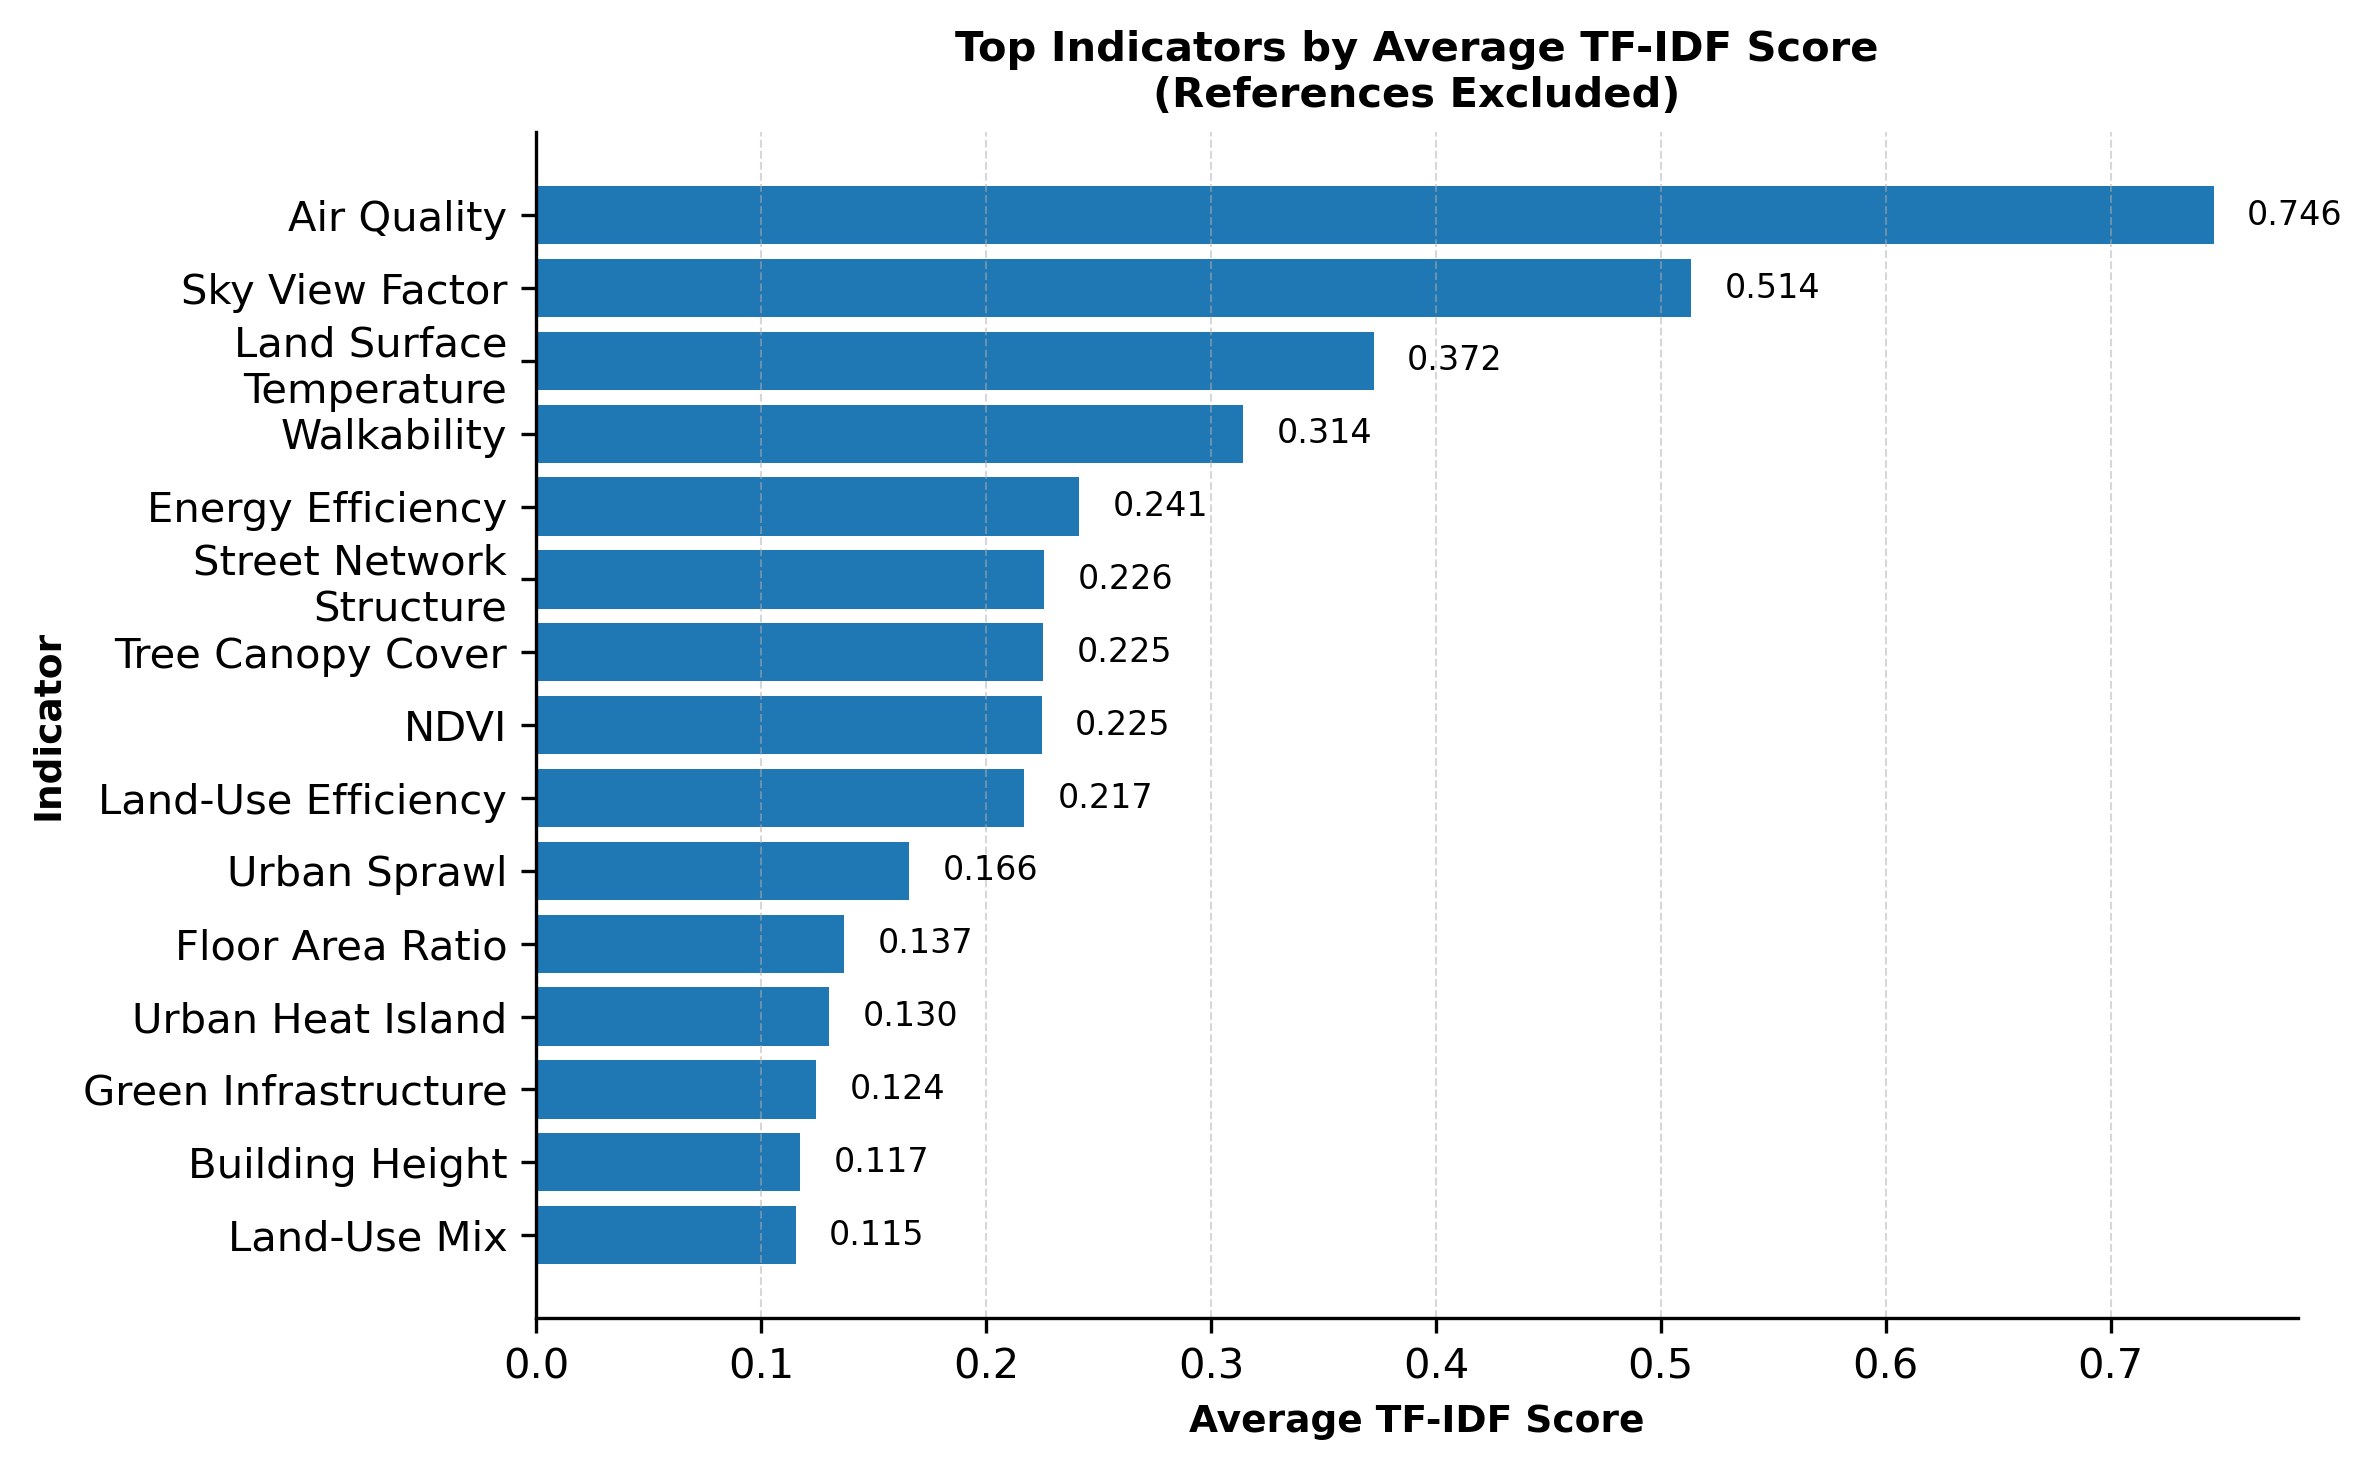

Saved figure → /Users/dwiprabowo/Downloads/greencompactcityurban/25/_outputs/tfidf_heatmap_noRef.png


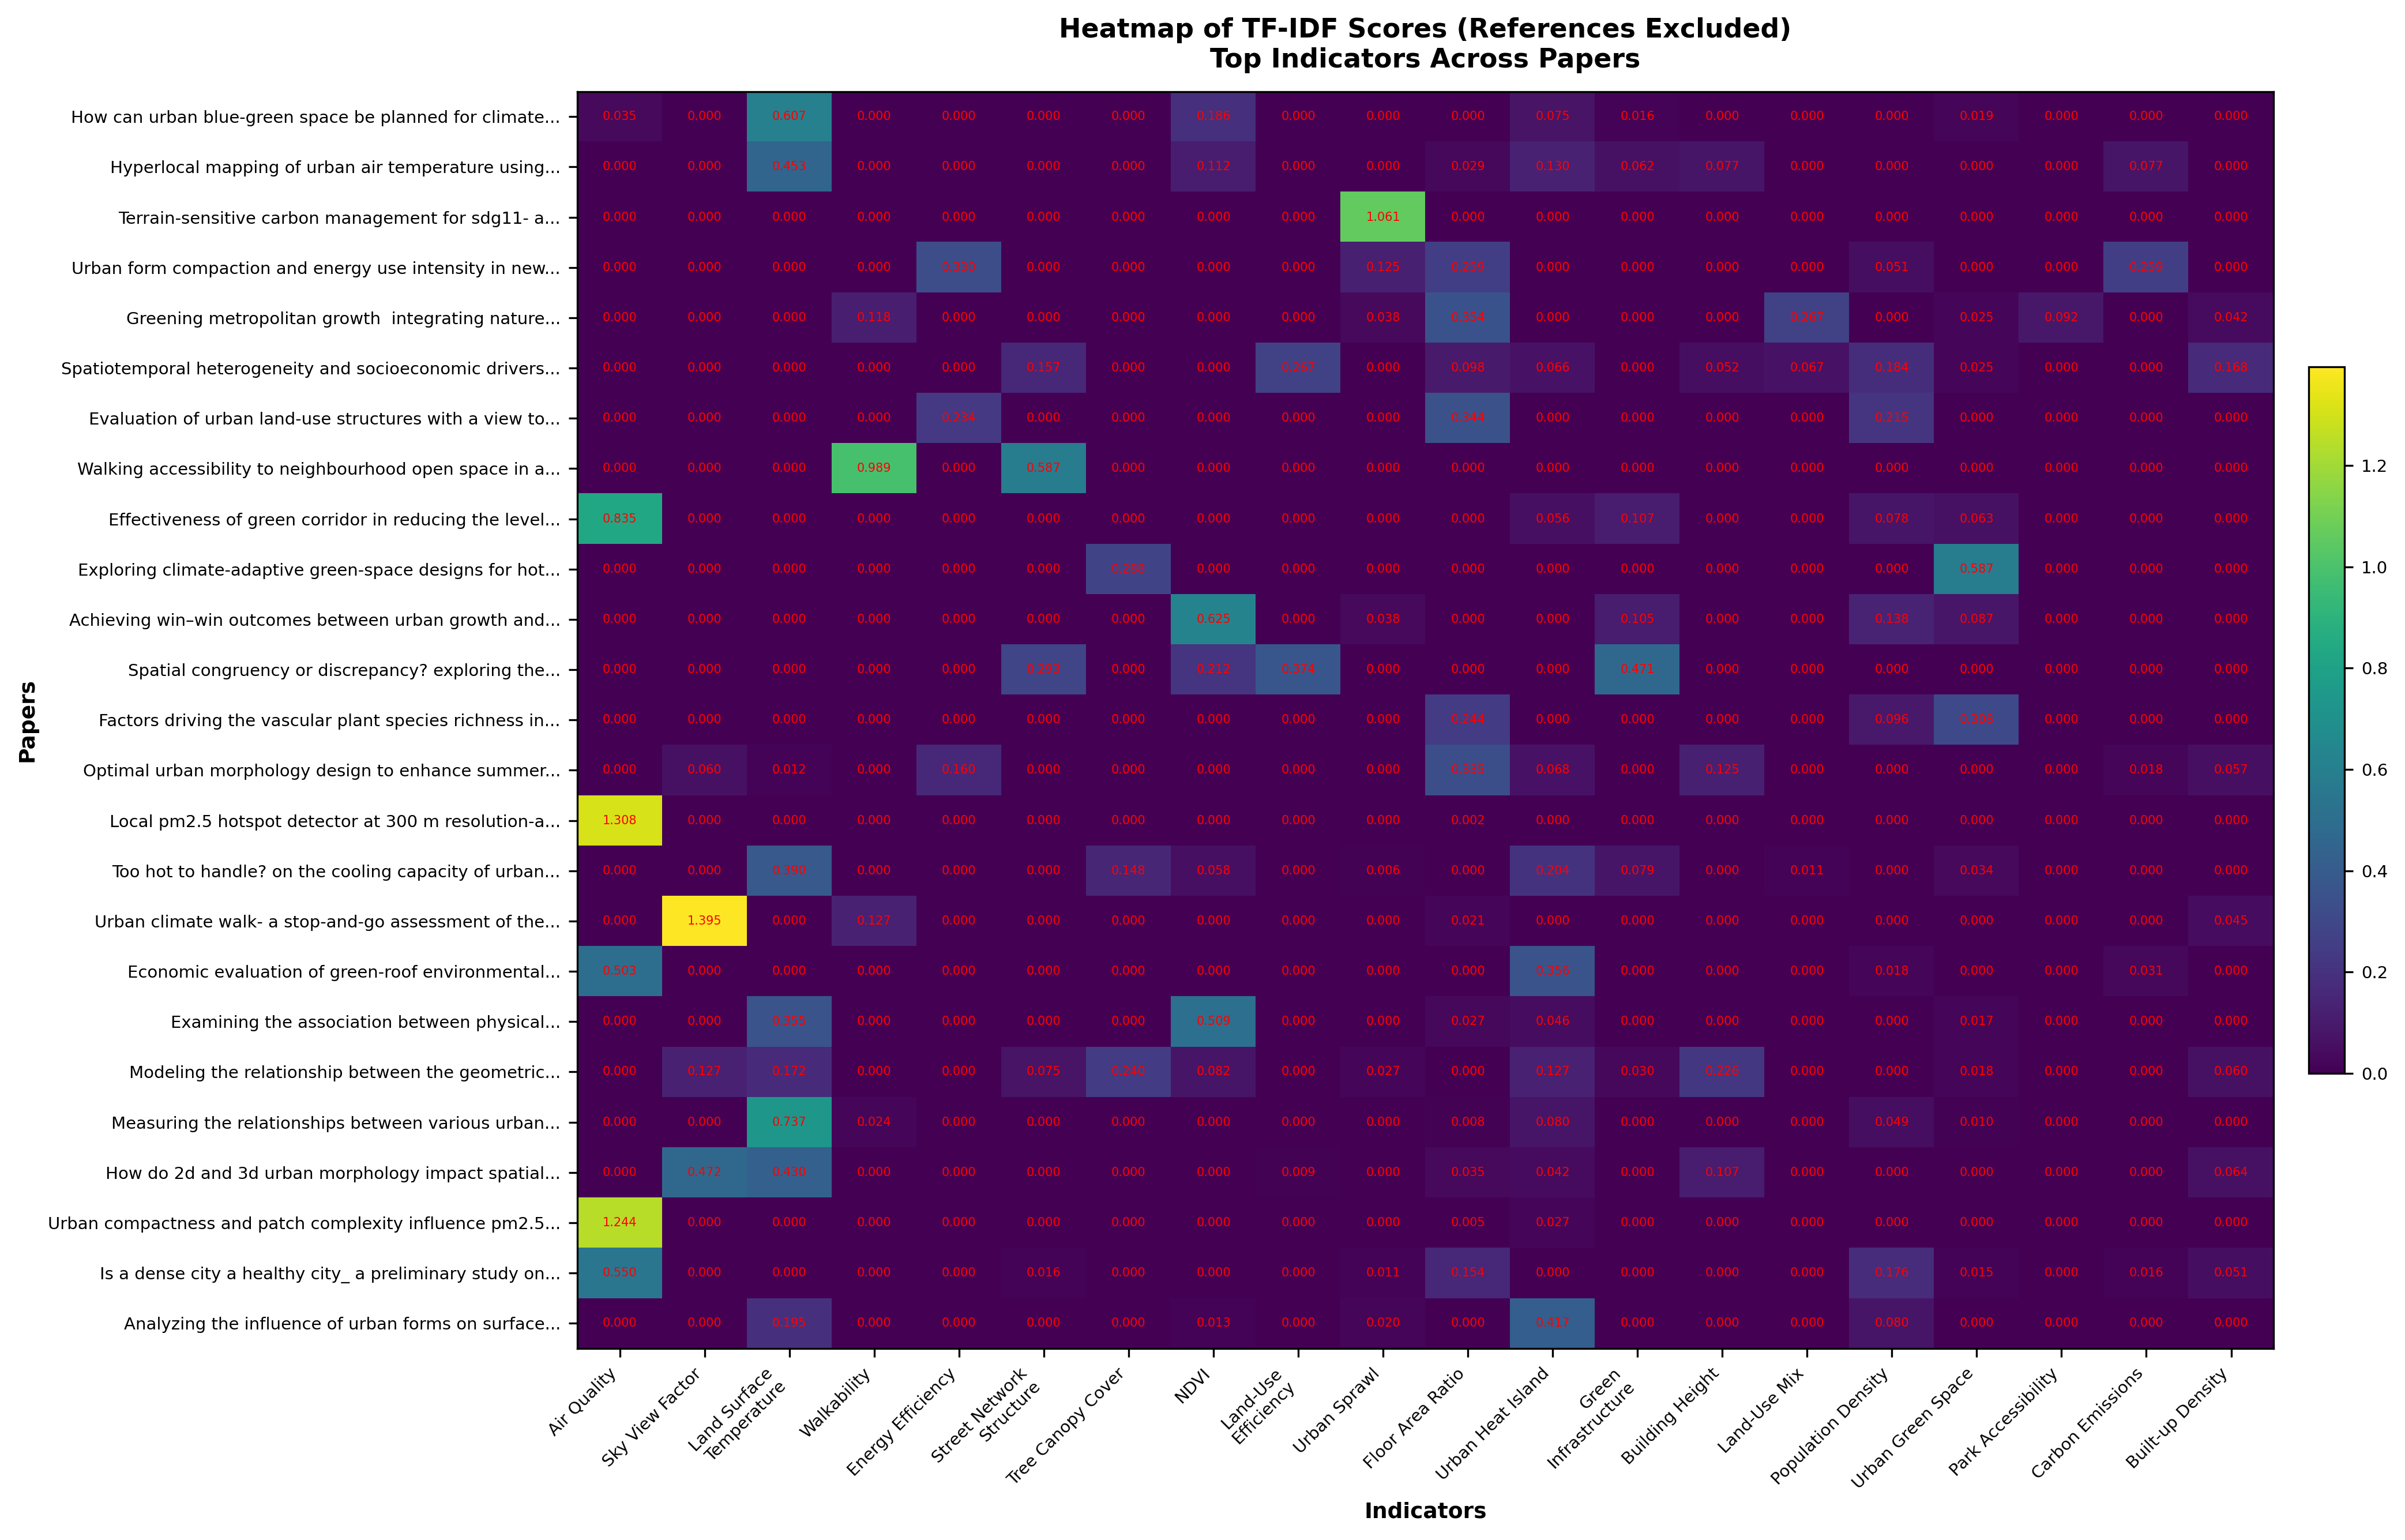


=== Aggregated TF-IDF by Dimension (5 Dimensions, no Ref) ===
                             Dimension  Indicator Count  Weighted TF-IDF
0  Climate & Environmental Performance                5         1.569889
1                   Morphology–Density                7         1.337385
2          Green & Blue Infrastructure                5         0.766592
3  Land-Use Mix & Functional Diversity                2         0.331978
4               Mobility–Accessibility                1         0.314332
Saved → /Users/dwiprabowo/Downloads/greencompactcityurban/25/_outputs/rq1_tfidf_dimension_summary.csv
Saved figure → /Users/dwiprabowo/Downloads/greencompactcityurban/25/_outputs/dimension_frequency_from_tfidf_noRef.png


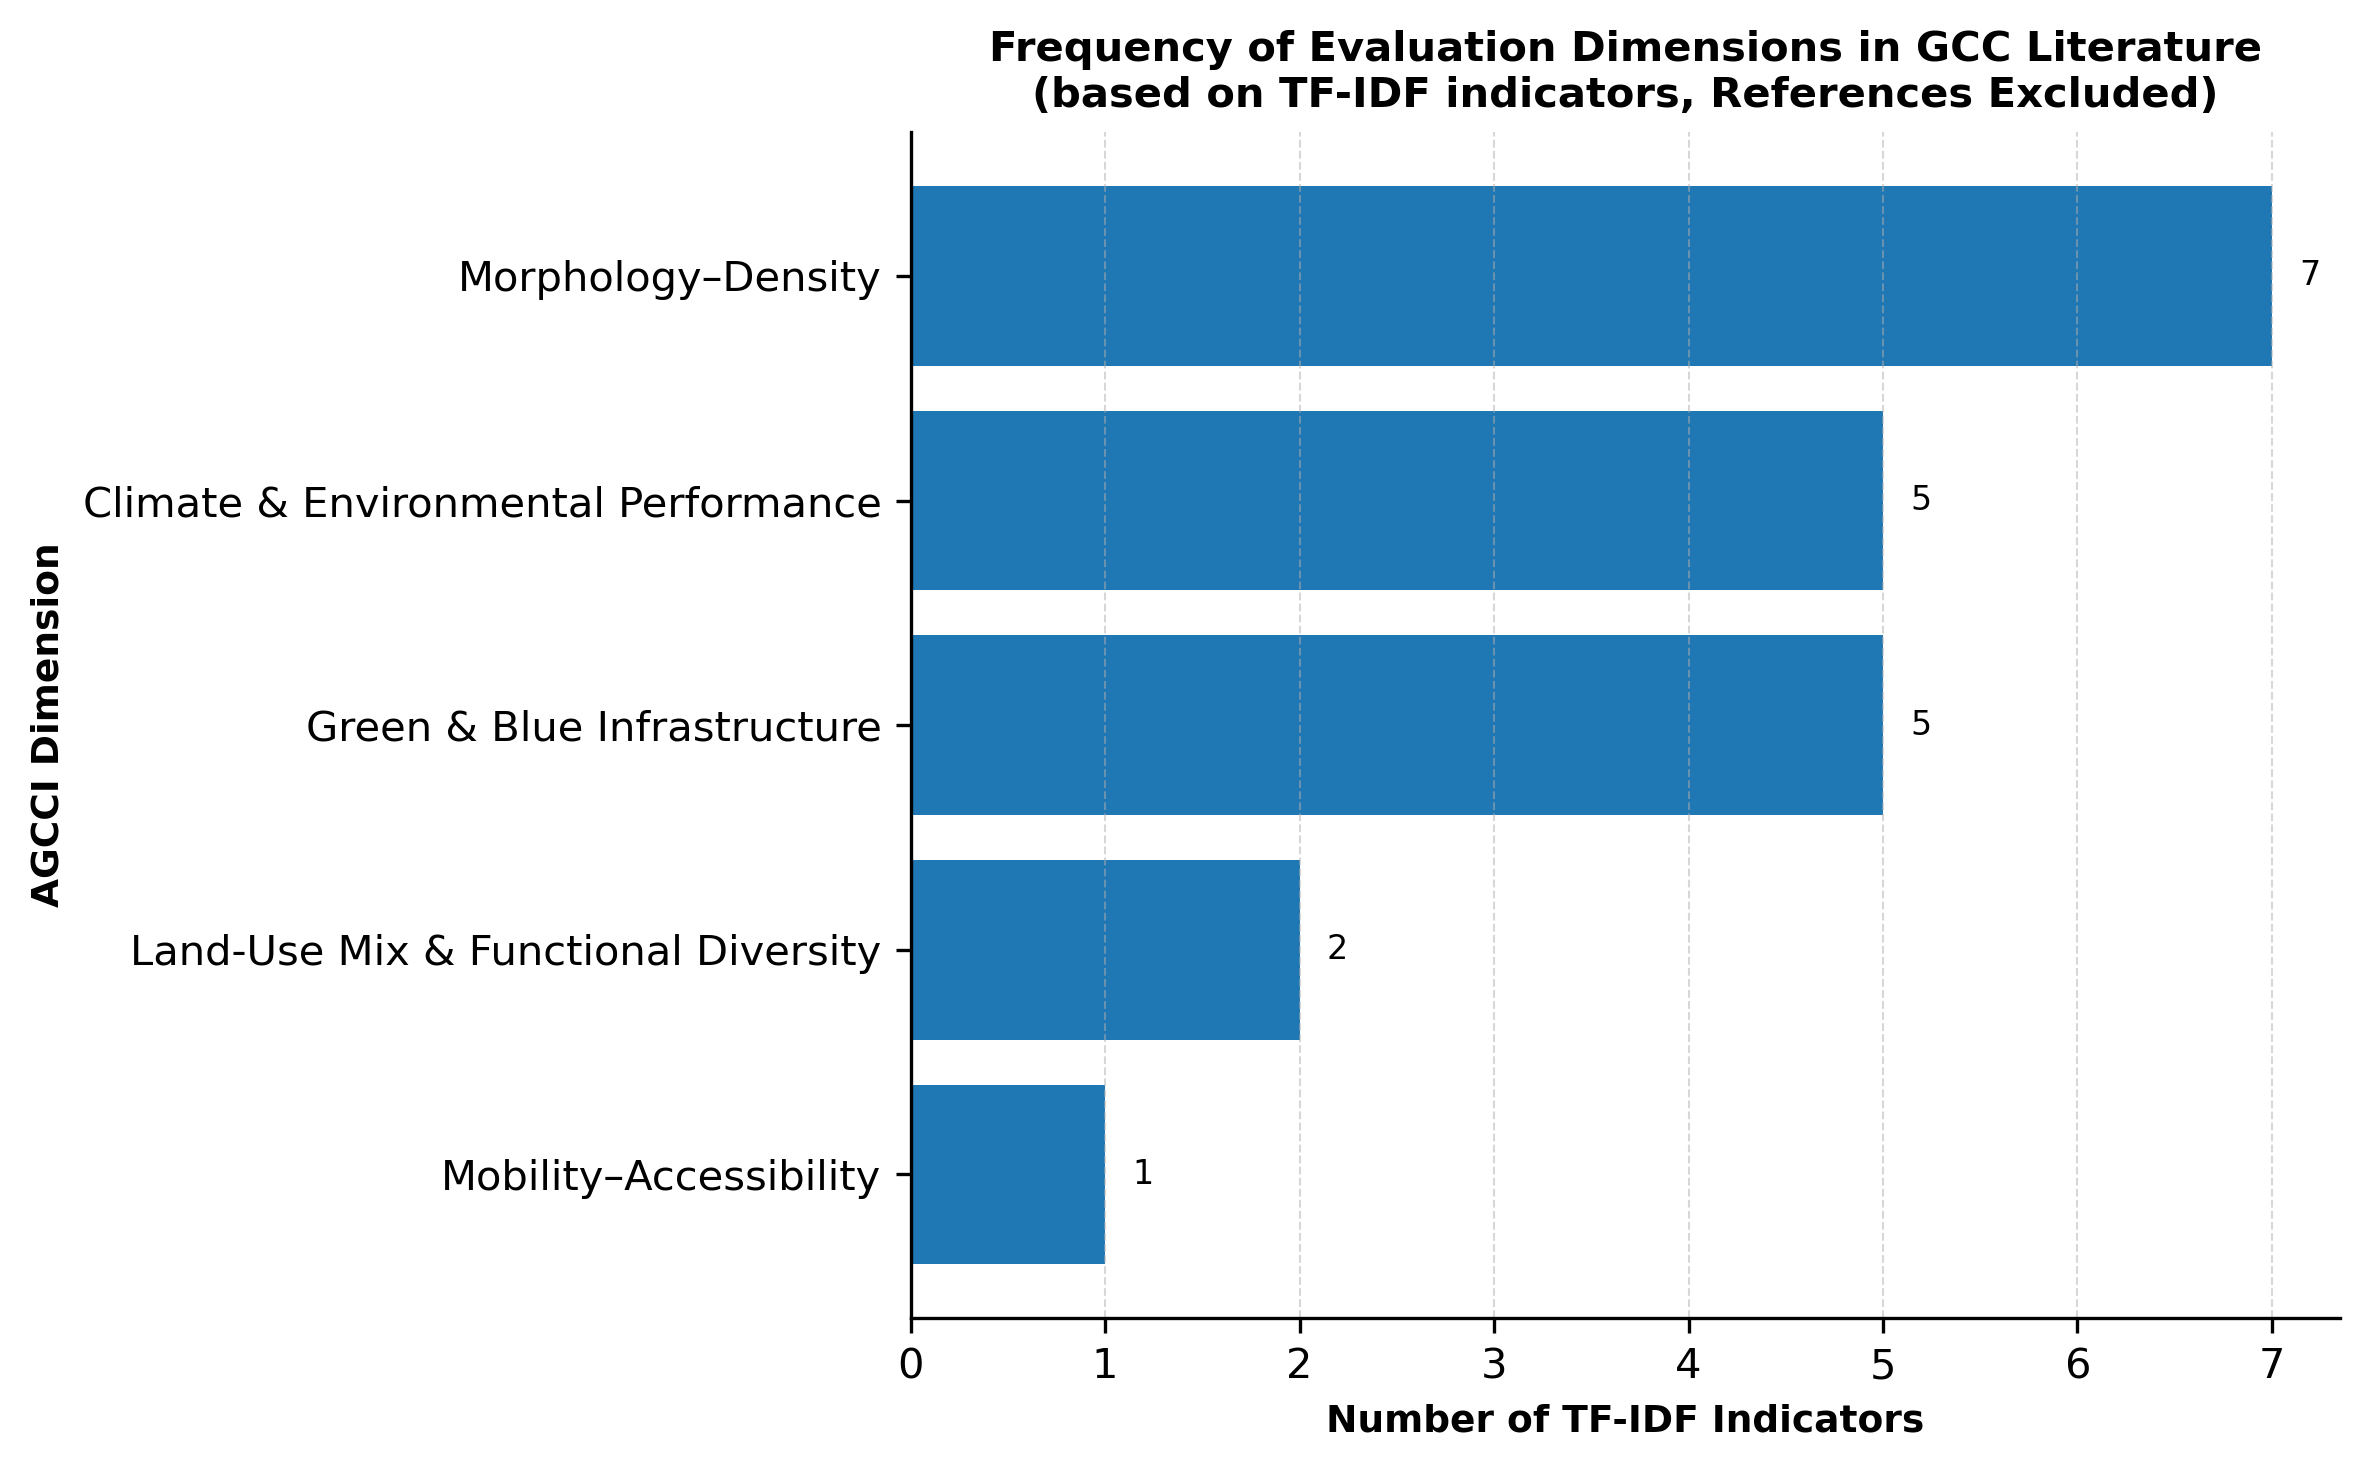

Excel saved → /Users/dwiprabowo/Downloads/greencompactcityurban/25/_outputs/tfidf_indicators_by_dimension_noRef.xlsx
Figure saved → /Users/dwiprabowo/Downloads/greencompactcityurban/25/_outputs/tfidf_indicators_by_dimension_table_noRef.png


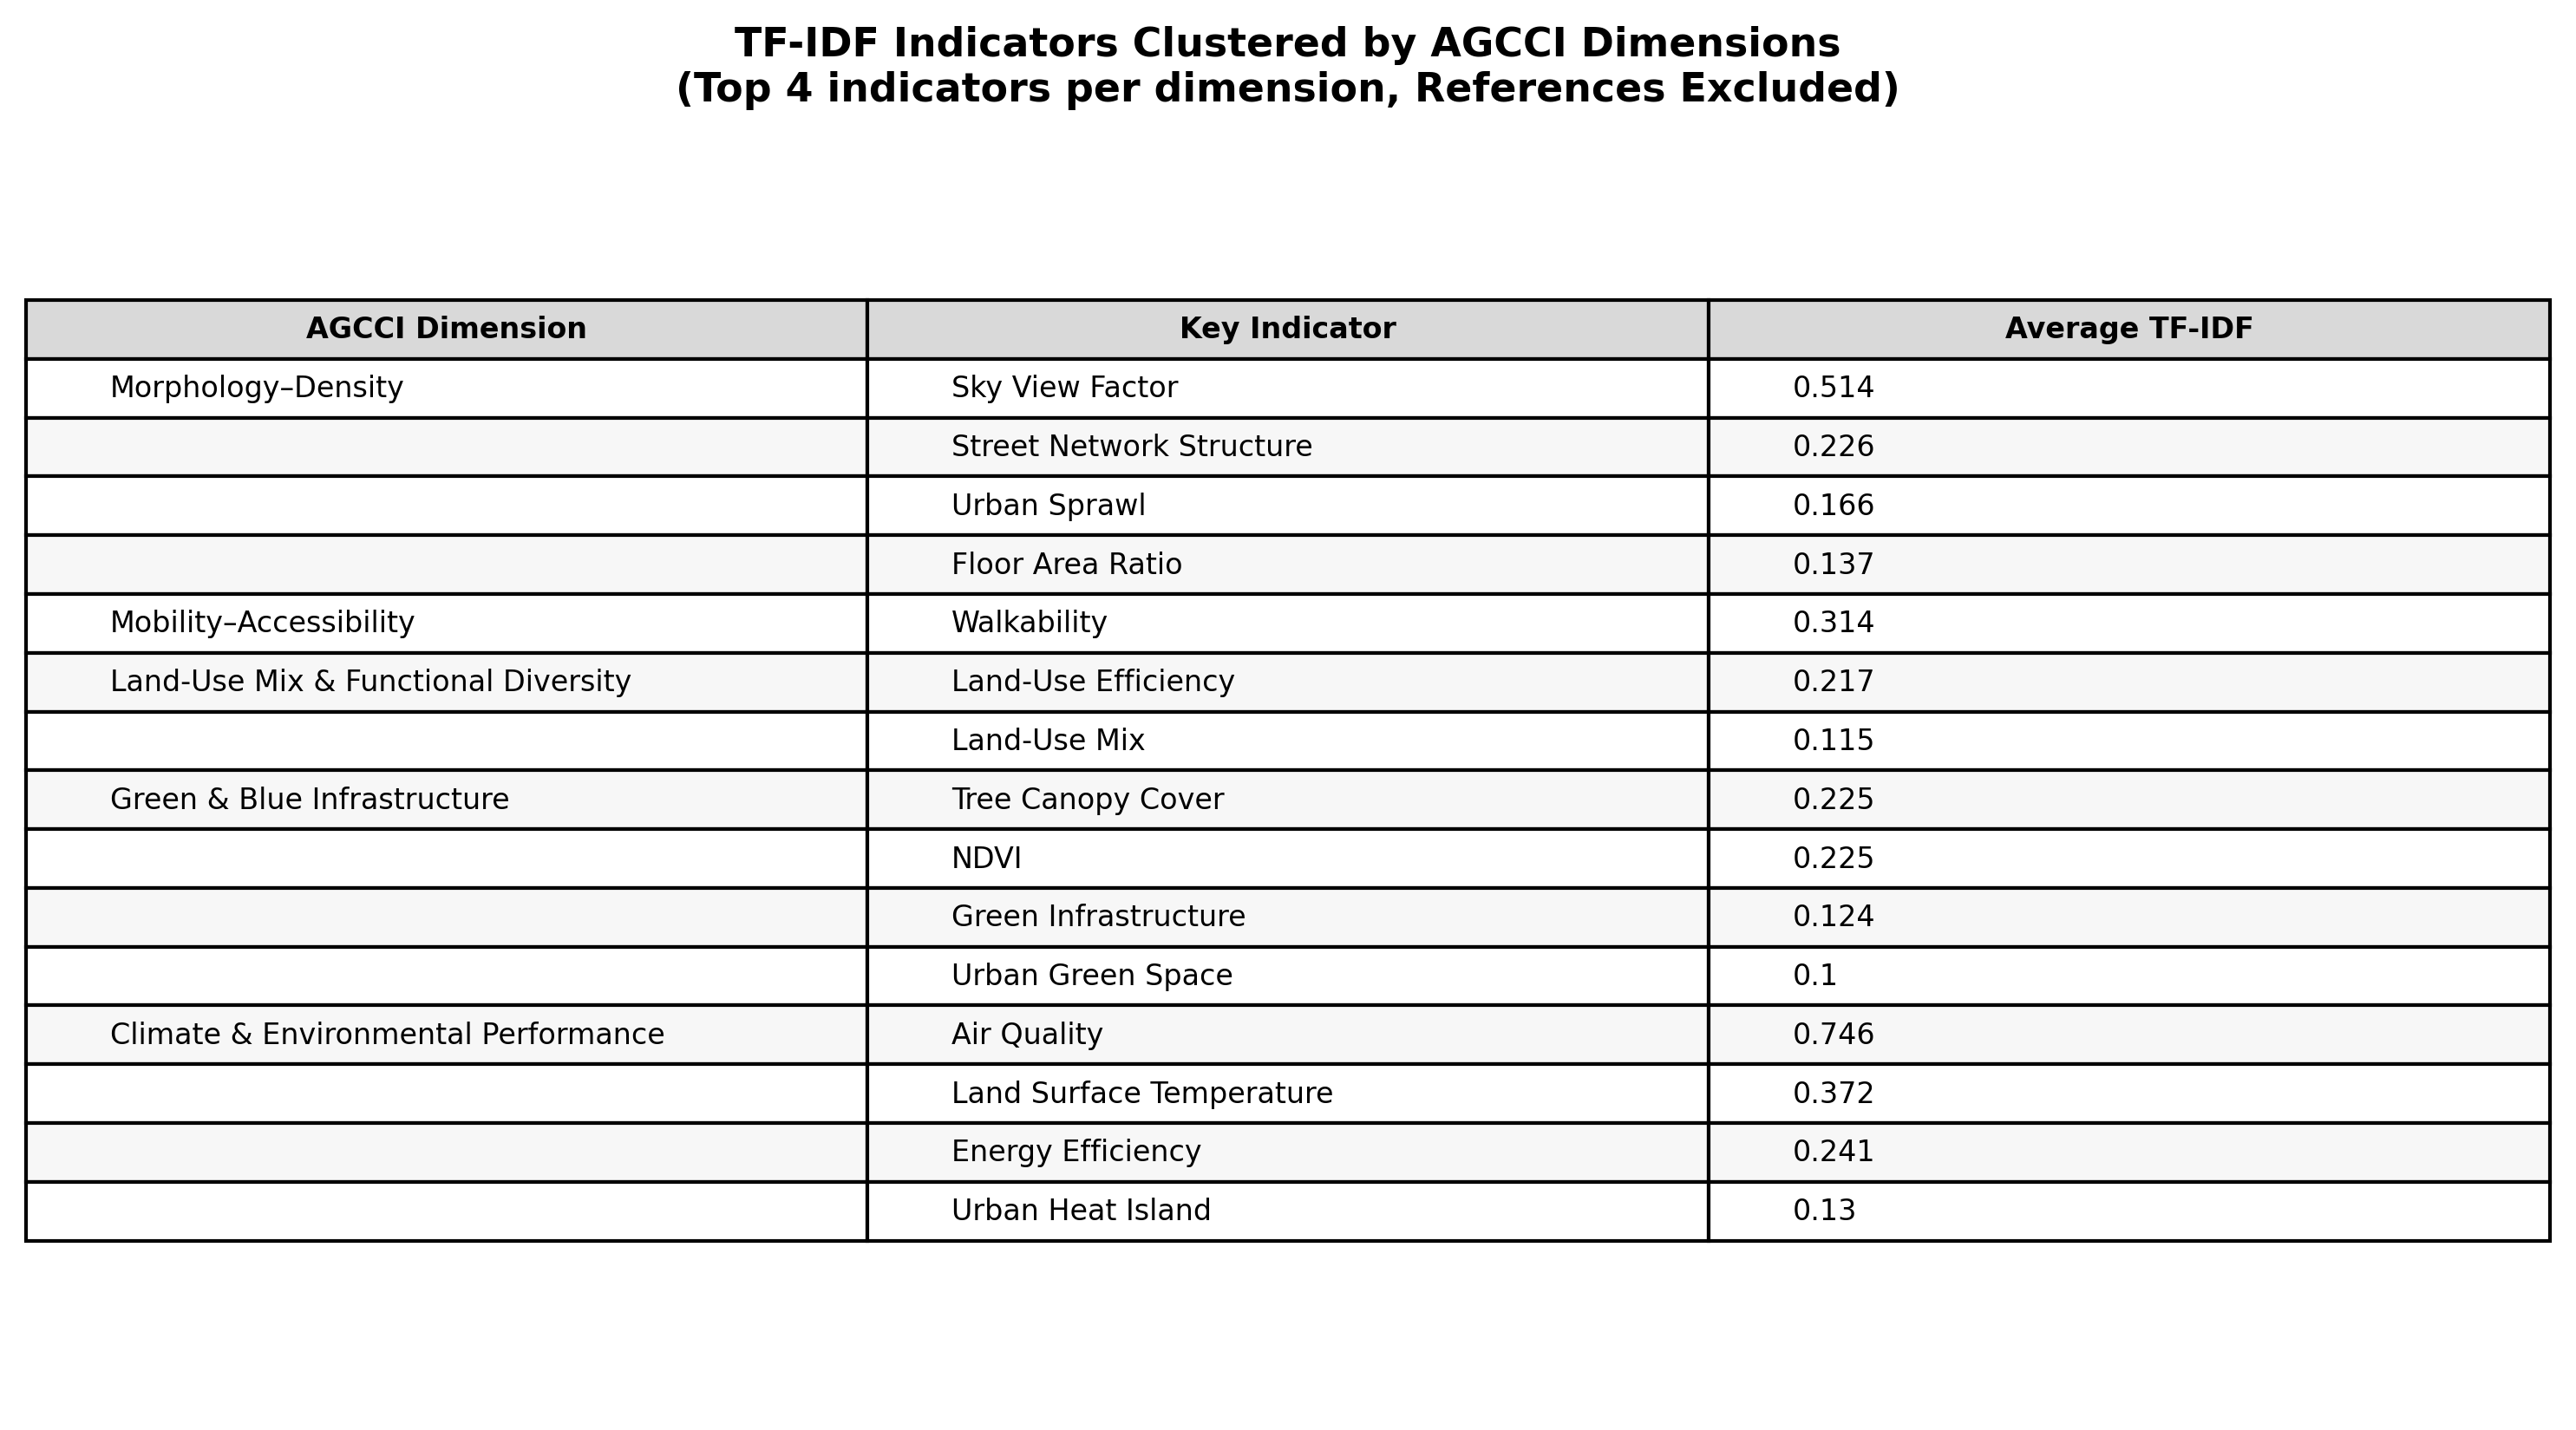


Files in out_dir now: ['dimension_frequency_from_tfidf_noRef.png', 'indicator_network_Q1_final_300dpi.png', 'rq1_frequency.csv', 'rq1_tfidf.csv', 'rq1_tfidf_dimension_summary.csv', 'tfidf_heatmap_noRef.png', 'tfidf_indicators_by_dimension_noRef.xlsx', 'tfidf_indicators_by_dimension_table_noRef.png', 'top_indicators_frequency_300dpi.png', 'top_indicators_tfidf_noRef.png']

TF-IDF analysis (References Excluded, Table A2) complete.


In [10]:
# ===============================================================
#   FULL PIPELINE (REVISED): TF-IDF + AGCCI (5 DIMENSIONS) + EXPORT CSV + JOURNAL TABLE
#   BASED ON Appendix A (Table A2) INDICATOR DICTIONARY
#   - Full text PDF extraction (PyMuPDF)
#   - References section removed (heuristic)
#   - Indicator detection uses Table A2 keywords (code-level matching)
#   - Analysis uses codes internally; VISUALS show ONLY canonical names (no codes)
#   - OUTPUTS are saved into: <PDF_FOLDER>/_outputs  (NOT CWD)
# ===============================================================

import os
import re
import textwrap
from collections import Counter

import fitz  # PyMuPDF
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ==========================================================
# 0) INDICATOR DICTIONARY (Appendix A - Table A2)
# - Keep codes for reproducibility
# - Use canonical + dimension for reporting
# ==========================================================

INDICATORS = {
    # (1) Morphology–Density
    "MOR_DEN": {"canonical": "Population Density", "dimension": "Morphology–Density", "ontology": "Metric",
                "keywords": ["population density", "inhabitants per hectare"]},
    "MOR_FAR": {"canonical": "Floor Area Ratio", "dimension": "Morphology–Density", "ontology": "Metric",
                "keywords": ["floor area ratio", "FAR", "plot ratio", "FSI"]},
    "MOR_BU": {"canonical": "Built-up Density", "dimension": "Morphology–Density", "ontology": "Metric",
               "keywords": ["built-up density", "building density"]},
    "MOR_HGT": {"canonical": "Building Height", "dimension": "Morphology–Density", "ontology": "Metric",
                "keywords": ["building height", "building storeys", "number of storeys"]},
    "MOR_COV": {"canonical": "Site Coverage", "dimension": "Morphology–Density", "ontology": "Metric",
                "keywords": ["site coverage", "building coverage ratio"]},
    "MOR_BLK": {"canonical": "Block Size", "dimension": "Morphology–Density", "ontology": "Metric",
                "keywords": ["block size", "urban block dimension"]},
    "MOR_NET": {"canonical": "Street Network Structure", "dimension": "Morphology–Density", "ontology": "Component",
                "keywords": ["street network", "road network"]},
    "MOR_SVF": {"canonical": "Sky View Factor", "dimension": "Morphology–Density", "ontology": "Metric",
                "keywords": ["sky view factor", "SVF"]},
    "MOR_SPL": {"canonical": "Urban Sprawl", "dimension": "Morphology–Density", "ontology": "Metric",
                "keywords": ["urban sprawl", "suburban sprawl"]},

    # (2) Mobility–Accessibility
    "MOB_WLK": {"canonical": "Walkability", "dimension": "Mobility–Accessibility", "ontology": "Metric",
                "keywords": ["walkability", "walk score"]},
    "MOB_BIK": {"canonical": "Bicycle Accessibility", "dimension": "Mobility–Accessibility", "ontology": "Metric",
                "keywords": ["bike accessibility", "cyclability"]},
    "MOB_PUB": {"canonical": "Public Transport Accessibility", "dimension": "Mobility–Accessibility", "ontology": "Metric",
                "keywords": ["public transit access", "transit accessibility"]},
    "MOB_CON": {"canonical": "Street Connectivity", "dimension": "Mobility–Accessibility", "ontology": "Metric",
                "keywords": ["street connectivity", "intersection density"]},
    "MOB_CTH": {"canonical": "Pedestrian Catchment Area", "dimension": "Mobility–Accessibility", "ontology": "Metric",
                "keywords": ["pedestrian catchment area", "pedestrian shed"]},
    "MOB_MOD": {"canonical": "Modal Split", "dimension": "Mobility–Accessibility", "ontology": "Metric",
                "keywords": ["modal split", "mode share"]},
    "MOB_TOD": {"canonical": "Transit-Oriented Development", "dimension": "Mobility–Accessibility", "ontology": "System",
                "keywords": ["transit-oriented development", "TOD"]},

    # (3) Land-Use Mix & Functional Diversity
    "LUM_MIX": {"canonical": "Land-Use Mix", "dimension": "Land-Use Mix & Functional Diversity", "ontology": "Metric",
                "keywords": ["land-use mix", "mixed land use"]},
    "LUM_ENT": {"canonical": "Entropy Index", "dimension": "Land-Use Mix & Functional Diversity", "ontology": "Metric",
                "keywords": ["entropy index", "land-use entropy"]},
    "LUM_JOB": {"canonical": "Jobs–Housing Balance", "dimension": "Land-Use Mix & Functional Diversity", "ontology": "Metric",
                "keywords": ["jobs–housing balance", "jobs-housing balance"]},
    "LUM_EFF": {"canonical": "Land-Use Efficiency", "dimension": "Land-Use Mix & Functional Diversity", "ontology": "Metric",
                "keywords": ["land-use efficiency", "land use efficiency"]},

    # (4) Green & Blue Infrastructure
    "GBI_SYS": {"canonical": "Green Infrastructure", "dimension": "Green & Blue Infrastructure", "ontology": "System",
                "keywords": ["green infrastructure", "green-blue infrastructure"]},
    "GBI_UGS": {"canonical": "Urban Green Space", "dimension": "Green & Blue Infrastructure", "ontology": "Component",
                "keywords": ["urban green space", "urban parks", "urban greenery"]},
    "GBI_CAN": {"canonical": "Tree Canopy Cover", "dimension": "Green & Blue Infrastructure", "ontology": "Metric",
                "keywords": ["tree canopy cover", "tree cover"]},
    "GBI_NDV": {"canonical": "NDVI", "dimension": "Green & Blue Infrastructure", "ontology": "Metric",
                "keywords": ["NDVI", "normalized difference vegetation index"]},
    "GBI_ACC": {"canonical": "Park Accessibility", "dimension": "Green & Blue Infrastructure", "ontology": "Metric",
                "keywords": ["park accessibility", "access to parks"]},
    "GBI_PER": {"canonical": "Permeable Surface Ratio", "dimension": "Green & Blue Infrastructure", "ontology": "Metric",
                "keywords": ["permeable surface ratio"]},
    "GBI_SUD": {"canonical": "Sustainable Urban Drainage Systems", "dimension": "Green & Blue Infrastructure", "ontology": "System",
                "keywords": ["SUDS", "sustainable urban drainage", "LID"]},

    # (5) Climate & Environmental Performance
    "CLM_UHI": {"canonical": "Urban Heat Island", "dimension": "Climate & Environmental Performance", "ontology": "Outcome Metric",
                "keywords": ["urban heat island", "UHI", "SUHI"]},
    "CLM_LST": {"canonical": "Land Surface Temperature", "dimension": "Climate & Environmental Performance", "ontology": "Outcome Metric",
                "keywords": ["land surface temperature", "LST"]},
    "CLM_AIR": {"canonical": "Air Quality", "dimension": "Climate & Environmental Performance", "ontology": "Outcome Metric",
                "keywords": ["air quality", "PM2.5", "NO2", "NO₂"]},
    "CLM_ENG": {"canonical": "Energy Efficiency", "dimension": "Climate & Environmental Performance", "ontology": "Outcome Metric",
                "keywords": ["energy efficiency", "energy use intensity"]},
    "CLM_CAR": {"canonical": "Carbon Emissions", "dimension": "Climate & Environmental Performance", "ontology": "Outcome Metric",
                "keywords": ["carbon emissions", "CO2 emissions", "CO₂ emissions"]},
}

DIMENSION_ORDER = [
    "Morphology–Density",
    "Mobility–Accessibility",
    "Land-Use Mix & Functional Diversity",
    "Green & Blue Infrastructure",
    "Climate & Environmental Performance",
]


# ==========================================================
# 1) Helpers
# ==========================================================
def normalize_text(s: str) -> str:
    if not s:
        return ""
    s = s.lower()
    s = (s.replace("no₂", "no2")
           .replace("co₂", "co2")
           .replace("pm₂.₅", "pm2.5")
           .replace("–", "-")
           .replace("—", "-"))
    s = re.sub(r"\s+", " ", s).strip()
    return s


def strip_references(full_text: str) -> str:
    text_lower = normalize_text(full_text)
    patterns = [
        r"\breferences\b",
        r"\bbibliography\b",
        r"\bworks cited\b",
        r"\breferences and notes\b",
        r"\bdaftar pustaka\b",
        r"\brujukan\b",
        r"참고문헌",
    ]
    cut_pos = None
    for pat in patterns:
        m = re.search(pat, text_lower)
        if m:
            cut_pos = m.start()
            break
    return full_text[:cut_pos] if cut_pos is not None else full_text


def to_sentence_case(text: str) -> str:
    text = (text or "").strip()
    if not text:
        return text
    t = text.lower()
    return t[0].upper() + t[1:]


def _kw_to_regex(kw: str) -> str:
    kw_norm = normalize_text(kw)
    escaped = re.escape(kw_norm)
    if re.fullmatch(r"[a-z0-9 \-\.]+", kw_norm):
        return r"\b" + escaped + r"\b"
    return escaped


def compile_indicator_patterns(indicators: dict) -> dict:
    compiled = {}
    for code, meta in indicators.items():
        pats = [_kw_to_regex(k) for k in meta["keywords"]]
        compiled[code] = re.compile("(" + "|".join(pats) + ")", flags=re.IGNORECASE)
    return compiled


INDICATOR_PATTERNS = compile_indicator_patterns(INDICATORS)


# ==========================================================
# 2) PDF Text Extraction
# ==========================================================
def extract_text_from_pdf(pdf_path: str) -> str:
    try:
        with fitz.open(pdf_path) as doc:
            return "\n".join([p.get_text("text") for p in doc])
    except Exception as e:
        print(f"Error reading {pdf_path}: {e}")
        return ""


# ==========================================================
# 3) TF (term counts) per document (References excluded)
# ==========================================================
def analyze_for_tfidf(pdf_folder: str) -> dict:
    """
    Returns:
        indicator_counts_per_doc: {filename: Counter({code: count, ...}), ...}
    """
    pdf_files = [f for f in os.listdir(pdf_folder) if f.lower().endswith(".pdf")]
    print(f"Found {len(pdf_files)} PDF files to process for TF-IDF.")

    indicator_counts_per_doc = {}

    for filename in pdf_files:
        print(f"--- Processing {filename} ---")
        file_path = os.path.join(pdf_folder, filename)

        full_text = extract_text_from_pdf(file_path)
        if not full_text:
            continue

        main_text = strip_references(full_text)
        text_lower = normalize_text(main_text)

        doc_counts = Counter()
        for code, rx in INDICATOR_PATTERNS.items():
            matches = rx.findall(text_lower)
            if matches:
                doc_counts[code] += len(matches)

        if doc_counts:
            indicator_counts_per_doc[filename] = doc_counts

    return indicator_counts_per_doc


# ==========================================================
# 4A) EXPORT RQ1 TF-IDF CSV  (key addition)
# ==========================================================
def export_rq1_tfidf_csv(counts_per_doc: dict, indicators_dict: dict, out_csv_path: str):
    """
    counts_per_doc: {filename: Counter({code: count, ...}), ...}
    Writes: rq1_tfidf.csv
    """
    total_docs = len(counts_per_doc)
    if total_docs == 0:
        raise ValueError("counts_per_doc is empty. Run analyze_for_tfidf() first.")

    # DF
    df_counter = Counter()
    for c in counts_per_doc.values():
        for code in c.keys():
            df_counter[code] += 1

    # IDF (smoothed)
    idf = {code: np.log((total_docs + 1) / (df + 1)) for code, df in df_counter.items()}

    # Avg TF-IDF
    collect = {}
    for doc, c in counts_per_doc.items():
        total_terms = sum(c.values())
        if total_terms == 0:
            continue
        for code, cnt in c.items():
            tf = cnt / total_terms
            sc = tf * idf.get(code, 0.0)
            collect.setdefault(code, []).append(sc)

    avg_tfidf = {code: float(np.mean(v)) for code, v in collect.items()}

    rows = []
    for code, score in avg_tfidf.items():
        meta = indicators_dict.get(code, {})
        rows.append({
            "Code": code,
            "Indicator": meta.get("canonical", code),
            "Dimension": meta.get("dimension", "NA"),
            "AvgTFIDF": round(score, 6),
            "DocFreq_n": int(df_counter.get(code, 0)),
            "DocFreq_share": round(df_counter.get(code, 0) / total_docs, 4),
            "TotalDocs": int(total_docs),
        })

    df = (pd.DataFrame(rows)
          .sort_values(["AvgTFIDF", "DocFreq_n"], ascending=[False, False])
          .reset_index(drop=True))

    out_dir = os.path.dirname(out_csv_path)
    if out_dir:
        os.makedirs(out_dir, exist_ok=True)

    df.to_csv(out_csv_path, index=False, encoding="utf-8")

    print("Saved rq1_tfidf.csv →", os.path.abspath(out_csv_path))
    print("File exists?", os.path.exists(out_csv_path))
    if os.path.exists(out_csv_path):
        print("Size (bytes):", os.path.getsize(out_csv_path))

    return df


# ==========================================================
# 4B) TF-IDF computation + outputs (Top bar + Heatmap) [SAVES INTO out_dir]
# ==========================================================
def calculate_and_analyze_tfidf(indicator_counts_per_doc: dict,
                               out_dir: str,
                               top_bar_n: int = 15,
                               heatmap_top_n: int = 30):
    total_docs = len(indicator_counts_per_doc)
    if total_docs == 0:
        print("No documents to analyze for TF-IDF.")
        return [], {}, {}

    os.makedirs(out_dir, exist_ok=True)

    # DF
    df_counter = Counter()
    for doc_counts in indicator_counts_per_doc.values():
        for code in doc_counts.keys():
            df_counter[code] += 1

    # IDF (smoothed)
    idf = {code: np.log((total_docs + 1) / (df + 1)) for code, df in df_counter.items()}

    # TF-IDF per doc
    tfidf_scores_per_doc = {}
    for doc_name, doc_counts in indicator_counts_per_doc.items():
        tfidf_scores_per_doc[doc_name] = {}
        total_terms = sum(doc_counts.values())
        if total_terms == 0:
            continue
        for code, cnt in doc_counts.items():
            tf = cnt / total_terms
            tfidf_scores_per_doc[doc_name][code] = tf * idf.get(code, 0.0)

    # Avg TF-IDF per code
    avg_collect = {}
    for doc_scores in tfidf_scores_per_doc.values():
        for code, sc in doc_scores.items():
            avg_collect.setdefault(code, []).append(sc)

    avg_tfidf = {code: float(np.mean(scores)) for code, scores in avg_collect.items()}
    sorted_codes = sorted(avg_tfidf.items(), key=lambda x: x[1], reverse=True)

    # Console
    print("\n" + "=" * 80)
    print("TF-IDF Analysis (References Excluded): Top Indicators (Table A2)")
    print("=" * 80)
    for code, score in sorted_codes[:top_bar_n]:
        cname = INDICATORS[code]["canonical"]
        dim = INDICATORS[code]["dimension"]
        print(f"{cname:<35} | {dim:<40}: {score:.4f}")

    # -------------------------
    # VIS 1: Bar chart (Top N)
    # -------------------------
    top_items = sorted_codes[:top_bar_n]
    labels = [INDICATORS[c]["canonical"] for c, _ in top_items]
    values = [v for _, v in top_items]
    wrapped = ["\n".join(textwrap.wrap(lab, width=22)) for lab in labels]

    fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")

    bars = ax.barh(wrapped, values)
    ax.invert_yaxis()

    ax.set_title("Top Indicators by Average TF-IDF Score\n(References Excluded)",
                 fontsize=10, fontweight="bold")
    ax.set_xlabel("Average TF-IDF Score", fontsize=9, fontweight="bold")
    ax.set_ylabel("Indicator", fontsize=9, fontweight="bold")

    ax.xaxis.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
    ax.yaxis.grid(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    vmax = max(values) if values else 1
    for bar, val in zip(bars, values):
        ax.text(bar.get_width() + vmax * 0.02,
                bar.get_y() + bar.get_height() / 2,
                f"{val:.3f}",
                va="center", ha="left", fontsize=8)

    plt.tight_layout()
    out_bar = os.path.join(out_dir, "top_indicators_tfidf_noRef.png")
    plt.savefig(out_bar, dpi=300, bbox_inches="tight", facecolor="white")
    print("Saved figure →", os.path.abspath(out_bar))
    plt.show()

    # -------------------------
    # VIS 2: Heatmap (Top N)
    # -------------------------
    top_codes_hm = [c for c, _ in sorted_codes[:heatmap_top_n]]

    rows = []
    row_names = []
    for doc_name, sc_map in tfidf_scores_per_doc.items():
        row = [sc_map.get(c, 0.0) for c in top_codes_hm]
        if sum(row) > 0:
            rows.append(row)
            row_names.append(doc_name)

    if rows:
        mat = np.array(rows)
        col_names = [INDICATORS[c]["canonical"] for c in top_codes_hm]

        cleaned = []
        for nm in row_names:
            base = os.path.splitext(nm)[0]
            base = re.sub(r"^\s*\d+\.\s*", "", base)
            base = to_sentence_case(base)
            if len(base) > 55:
                cut = base[:55]
                if " " in cut:
                    cut = cut.rsplit(" ", 1)[0]
                base = cut + "..."
            cleaned.append(base)

        fig, ax = plt.subplots(figsize=(14, 9), dpi=300)
        fig.patch.set_facecolor("white")
        ax.set_facecolor("white")

        im = ax.imshow(mat, aspect="auto")
        cbar = plt.colorbar(im, ax=ax, fraction=0.02, pad=0.02)
        cbar.ax.tick_params(labelsize=7)

        ax.set_title("Heatmap of TF-IDF Scores (References Excluded)\nTop Indicators Across Papers",
                     fontsize=11, fontweight="bold", pad=10)
        ax.set_xlabel("Indicators", fontsize=9, fontweight="bold")
        ax.set_ylabel("Papers", fontsize=9, fontweight="bold")

        ax.set_xticks(np.arange(len(col_names)))
        ax.set_yticks(np.arange(len(cleaned)))

        ax.set_xticklabels([("\n".join(textwrap.wrap(c, 18))) for c in col_names],
                           rotation=45, ha="right", fontsize=7)
        ax.set_yticklabels(cleaned, fontsize=7)

        if mat.shape[0] * mat.shape[1] <= 900:
            for i in range(mat.shape[0]):
                for j in range(mat.shape[1]):
                    ax.text(j, i, f"{mat[i, j]:.3f}",
                            ha="center", va="center", fontsize=5, color="red")

        plt.tight_layout()
        out_hm = os.path.join(out_dir, "tfidf_heatmap_noRef.png")
        plt.savefig(out_hm, dpi=300, bbox_inches="tight", facecolor="white")
        print("Saved figure →", os.path.abspath(out_hm))
        plt.show()

    return sorted_codes, tfidf_scores_per_doc, avg_tfidf


# ==========================================================
# 5) Aggregate TF-IDF by AGCCI dimensions
# ==========================================================
def aggregate_by_dimension(sorted_tfidf_codes, indicators_dict=INDICATORS):
    dim_counts = {d: 0 for d in DIMENSION_ORDER}
    dim_scores = {d: 0.0 for d in DIMENSION_ORDER}
    unmatched = []

    for code, score in sorted_tfidf_codes:
        meta = indicators_dict.get(code)
        if not meta:
            unmatched.append(code)
            continue
        dim = meta["dimension"]
        if dim not in dim_counts:
            dim_counts.setdefault(dim, 0)
            dim_scores.setdefault(dim, 0.0)
        dim_counts[dim] += 1
        dim_scores[dim] += float(score)

    return dim_counts, dim_scores, unmatched


def list_indicators_by_dimension(sorted_tfidf_codes, indicators_dict=INDICATORS):
    grouped = {d: [] for d in DIMENSION_ORDER}
    grouped["Unmatched"] = []

    for code, score in sorted_tfidf_codes:
        meta = indicators_dict.get(code)
        if not meta:
            grouped["Unmatched"].append((code, round(float(score), 4)))
            continue
        dim = meta["dimension"]
        cname = meta["canonical"]
        grouped.setdefault(dim, []).append((cname, round(float(score), 4)))

    for dim in grouped:
        grouped[dim] = sorted(grouped[dim], key=lambda x: x[1], reverse=True)

    return grouped


# ==========================================================
# 6) MAIN  (outputs saved into <PDF_FOLDER>/_outputs)
# ==========================================================
if __name__ == "__main__":
    PDF_FOLDER = "/Users/dwiprabowo/Downloads/greencompactcityurban/25"

    out_dir = os.path.join(PDF_FOLDER, "_outputs")
    os.makedirs(out_dir, exist_ok=True)
    print("CWD =", os.getcwd())
    print("Output dir =", os.path.abspath(out_dir))

    print("\n===== Starting TF-IDF Analysis (References Excluded, Table A2) =====")
    counts_per_doc = analyze_for_tfidf(PDF_FOLDER)

    print("Docs with detected indicators:", len(counts_per_doc))
    if not counts_per_doc:
        print("\nNo PDF indicators detected.")
        raise SystemExit

    # ---- ADDED: export rq1_tfidf.csv ----
    export_rq1_tfidf_csv(
        counts_per_doc,
        indicators_dict=INDICATORS,
        out_csv_path=os.path.join(out_dir, "rq1_tfidf.csv")
    )

    # Compute TF-IDF + figures (saved to out_dir)
    tfidf_sorted, tfidf_scores_per_doc, avg_tfidf = calculate_and_analyze_tfidf(
        counts_per_doc,
        out_dir=out_dir,
        top_bar_n=15,
        heatmap_top_n=30
    )

    # Aggregate by dimension
    dim_counts, dim_scores, unmatched_codes = aggregate_by_dimension(tfidf_sorted)

    dim_df = pd.DataFrame({
        "Dimension": list(dim_counts.keys()),
        "Indicator Count": list(dim_counts.values()),
        "Weighted TF-IDF": [dim_scores[d] for d in dim_counts.keys()],
    })

    dim_df["Dimension"] = pd.Categorical(dim_df["Dimension"], categories=DIMENSION_ORDER, ordered=True)
    dim_df = dim_df.sort_values("Weighted TF-IDF", ascending=False).reset_index(drop=True)

    print("\n=== Aggregated TF-IDF by Dimension (5 Dimensions, no Ref) ===")
    print(dim_df)

    # Save dim_df table
    out_dim_csv = os.path.join(out_dir, "rq1_tfidf_dimension_summary.csv")
    dim_df.to_csv(out_dim_csv, index=False)
    print("Saved →", os.path.abspath(out_dim_csv))

    # Dimension frequency chart (saved to out_dir)
    dim_df_sorted = dim_df.sort_values(by="Indicator Count", ascending=False)

    fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")

    bars = ax.barh(dim_df_sorted["Dimension"], dim_df_sorted["Indicator Count"])
    ax.invert_yaxis()

    ax.set_title(
        "Frequency of Evaluation Dimensions in GCC Literature\n"
        "(based on TF-IDF indicators, References Excluded)",
        fontsize=10, fontweight="bold"
    )
    ax.set_xlabel("Number of TF-IDF Indicators", fontsize=9, fontweight="bold")
    ax.set_ylabel("AGCCI Dimension", fontsize=9, fontweight="bold")

    ax.xaxis.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
    ax.yaxis.grid(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    max_val = dim_df_sorted["Indicator Count"].max() if len(dim_df_sorted) else 1
    for bar, val in zip(bars, dim_df_sorted["Indicator Count"]):
        ax.text(bar.get_width() + max_val * 0.02,
                bar.get_y() + bar.get_height() / 2,
                f"{int(val)}",
                va="center", ha="left", fontsize=8)

    plt.tight_layout()
    out_dim_fig = os.path.join(out_dir, "dimension_frequency_from_tfidf_noRef.png")
    plt.savefig(out_dim_fig, dpi=300, bbox_inches="tight", facecolor="white")
    print("Saved figure →", os.path.abspath(out_dim_fig))
    plt.show()

    # List indicators by dimension (canonical only) -> Excel (saved to out_dir)
    grouped = list_indicators_by_dimension(tfidf_sorted)

    rows = []
    for dim, items in grouped.items():
        if dim == "Unmatched":
            continue
        for cname, score in items:
            rows.append({"Dimension": dim, "Indicator": cname, "Avg TF-IDF Score": score})

    df_dim_ind = pd.DataFrame(rows)
    df_dim_ind["Dimension"] = pd.Categorical(df_dim_ind["Dimension"], categories=DIMENSION_ORDER, ordered=True)
    df_dim_ind = df_dim_ind.sort_values(["Dimension", "Avg TF-IDF Score"],
                                        ascending=[True, False]).reset_index(drop=True)

    out_xlsx = os.path.join(out_dir, "tfidf_indicators_by_dimension_noRef.xlsx")
    df_dim_ind.to_excel(out_xlsx, index=False)
    print("Excel saved →", os.path.abspath(out_xlsx))

    # Journal-style table figure: top N indicators per dimension (saved to out_dir)
    top_n_per_dim = 4
    df_fig = (df_dim_ind.groupby("Dimension", group_keys=False)
              .head(top_n_per_dim)
              .reset_index(drop=True))
    df_fig["Avg TF-IDF Score"] = df_fig["Avg TF-IDF Score"].round(3)

    display_dims = []
    last = None
    for d in df_fig["Dimension"]:
        if d == last:
            display_dims.append("")
        else:
            display_dims.append(str(d))
            last = d

    df_table = df_fig.copy()
    df_table["AGCCI Dimension"] = display_dims
    df_table = df_table[["AGCCI Dimension", "Indicator", "Avg TF-IDF Score"]]
    df_table.rename(columns={"Indicator": "Key Indicator", "Avg TF-IDF Score": "Average TF-IDF"}, inplace=True)

    col_labels = list(df_table.columns)
    table_data = df_table.values.tolist()

    n_rows = len(table_data) + 1
    fig_h = max(3, 0.35 * n_rows)

    fig, ax = plt.subplots(figsize=(10, fig_h), dpi=300)
    ax.axis("off")

    table = ax.table(cellText=table_data, colLabels=col_labels, loc="center", cellLoc="left")
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.2)

    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight="bold", color="black")
            cell.set_facecolor("#D9D9D9")
        else:
            cell.set_facecolor("#F7F7F7" if row % 2 == 0 else "white")

    plt.title(
        f"TF-IDF Indicators Clustered by AGCCI Dimensions\n"
        f"(Top {top_n_per_dim} indicators per dimension, References Excluded)",
        fontsize=11, fontweight="bold", pad=10
    )

    plt.tight_layout()
    out_tbl = os.path.join(out_dir, "tfidf_indicators_by_dimension_table_noRef.png")
    plt.savefig(out_tbl, dpi=300, bbox_inches="tight", facecolor="white")
    print("Figure saved →", os.path.abspath(out_tbl))
    plt.show()

    if unmatched_codes:
        print("\nUnmatched codes (should be empty):")
        print(unmatched_codes)

    print("\nFiles in out_dir now:", sorted(os.listdir(out_dir)))
    print("\nTF-IDF analysis (References Excluded, Table A2) complete.")
